In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [2]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import copy
import pylab

In [3]:
def getARMA(data, A=0, C=0):
    A_free=A
    C_free=C
    model = modelling.PEM(data, A=A, C=C)
    if isinstance(A, int):
        A_free = [1]*(A+1)
    if isinstance(C, int):
        C_free = [1]*(C+1)
    model.set_free_params(A_free=A_free, C_free=C_free)
    model_fitted = model.fit(method='LS', bh=False)
    model_fitted.summary()
    return model_fitted


def checkNormal(data, remove=False, title=None):
    if remove:
        data = data[remove:]
    tests.check_if_normal(data)
    stats.probplot(data, dist="norm", plot=pylab)
    if title:
        plt.title(title)
    pylab.show()
    
    
def analyzeARMA(x, A=0, C=0, noLags=50, titleStr=None, return_val=False, normal_test=True, remove=False):
    model = getARMA(x, A=A, C=C)
    if isinstance(A, int): len_A = A
    else: len_A = len(A)
    if isinstance(C, int): len_C = C
    else: len_C = len(C)
    remove=max(len_A, len_C)
    res = model.resid
    acf_est, pacf_est = analysis.plotACFnPACF(res,noLags=noLags,titleStr=titleStr, return_val=True)
    tests.whiteness_test(res)
    if normal_test:
        checkNormal(acf_est, remove=remove, title='ACF')
        checkNormal(pacf_est, remove=remove, title='PACF')
    if return_val:
        return model, acf_est, pacf_est

    
def pred_k(y, A, C, s=0, k=[1], plot=True, transform=False, inv_transform=False):
    
    # Initialize important variables
    if s>0:
        Astar = np.convolve(A, [1] + [0]*(s-1) + [-1])
    noise_var_dict = {}
    yhat_k_df = pd.DataFrame({'True_val': y})
    
    # Transform data before calculating prediction
    y_transform = y.copy()
    if transform:
        y_transform = [transform(val) for val in y]
    for i in range(len(k)):
        Fk, Gk = modelling.polydiv(C, A, k[i])
        remove = max(len(Gk), len(C))
        yhat_k = modelling.filter(Gk, C, y_transform, remove=remove).tolist()
        
        # Transform data back
        if transform:
            yhat_k = [inv_transform(val) for val in yhat_k]
            # y = [inv_transform(val) for val in y]
        yhat_k_df[f'{k[i]}-step_pred'] = [np.NaN]*remove + yhat_k
        
        # Calculate prediction
        pred_error = y[len(y)-len(yhat_k):] - np.array(yhat_k)
        noise_var = np.var(pred_error)
        noise_var_dict[k[i]] = noise_var
        print(f'Estimate noise variance for {k[i]}-step prediction is {round(noise_var,4)}')
    
    # plot the results and return yhat and noise variance
    yhat_k_df.dropna().plot(title='Prediction')
    return yhat_k_df, noise_var_dict

# Import data

In [4]:
ElGeneina_mat = analysis.mat2np('./data/ElGeneina.mat')[0]
Kassala_mat = analysis.mat2np('./data/Kassala.mat')[0]

In [5]:
ElGeneina = pd.DataFrame()
col_names = ['nvdi', 'nvdi_t', 'rain', 'rain_t', 'rain_org', 'rain_org_t']
for i in range(len(ElGeneina_mat)):
    ElGeneina = pd.concat([ElGeneina, pd.DataFrame(ElGeneina_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
ElGeneina.columns = col_names
    
Kassala = pd.DataFrame()
for i in range(len(Kassala_mat)):
    Kassala = pd.concat([Kassala, pd.DataFrame(Kassala_mat[i]).astype(float).round(6)], axis=1, ignore_index=True)
Kassala.columns = col_names
ElGeneina.head(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t
0,140.2,1982.013889,0.0,1960.013889,0.0,1960.041667
1,147.2,1982.041667,0.0,1960.041667,0.0,1960.125000
2,145.7,1982.069444,0.0,1960.069444,0.0,1960.208333
3,145.8,1982.097222,0.0,1960.097222,0.0,1960.291667
4,145.0,1982.125000,0.0,1960.125000,0.0,1960.375000
5,140.2,1982.152778,0.0,1960.152778,17.2,1960.458333
6,142.6,1982.180556,0.0,1960.180556,233.2,1960.541667
7,142.7,1982.208333,0.0,1960.208333,219.4,1960.625000
8,144.6,1982.236111,0.0,1960.236111,78.7,1960.708333
9,146.3,1982.263889,0.0,1960.263889,6.1,1960.791667


- High NDVI indicates presence of vegetation
- Low NDVI indicates barren ground, water, snow, ice, etc
- NDVI are stored as unsigned (8-bit) integers (i.e., between 0 and 255), and thus needs to be rescaled to [−1,1].
- NDVI is measured three times every month (day 1-10, 11-20, 21-end) 
- Rain_org is measured once every month
- Rain is linear interpolation of Rain_org to match NDVI
- Both NDVI and rain data had missing data points but were filled with Matlab misdata function.

# Recursive reconstruction of rain data

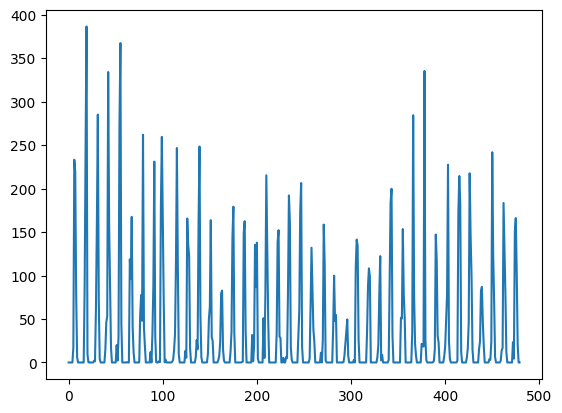

In [6]:
plt.plot(ElGeneina['rain_org'])
plt.show()

## Transforming data

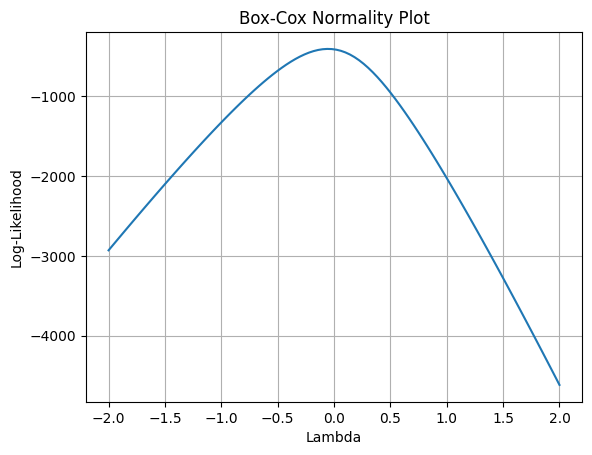

Max Lambda = -0.052951918377049746.
ln(y) could be an appropriate transformation.


In [7]:
# Here we add a very small value to allow y to be strictly positive.
y = ElGeneina['rain_org'].values
y = y[:len(y)-960]
y = y + 1e-2
max_lambda = analysis.box_cox(y, 1)

Although ln(y) is an appropriate transformation, the structure of $Y_t = x_t + x_{t-1} + x_{t-2}$ makes it difficult for us to revert the transformation back. Using the estimation $\ln{Y_t} =  \ln{x_t} + \ln{x_{t-1}} + \ln{x_{t-2}}$ does not give us a good estimate. Hence, we will be using no transformation here.

In [8]:
# rain_df = pd.merge(Kassala['rain_t'], Kassala[['rain_org_t', 'rain_org']], how='outer', left_on='rain_t', right_on='rain_org_t').sort_values('rain_t').dropna(axis=0, how='all')
# rain_df['rain_org'] = rain_df['rain_org'].apply(lambda x: np.log(x+1e-8) if pd.notnull(x) else x)
# y = rain_df['rain_org'].values
# rain_df.tail(15)

## Modelling rain with Kalman

Here we estimate the optimal AR(1) coeffeicient to use, limiting the options to have the polynomial roots inside the unit circle to have the process stable.

minimum value of a1 that minimizes the error is -0.99
estimated variance of residual is 41.73


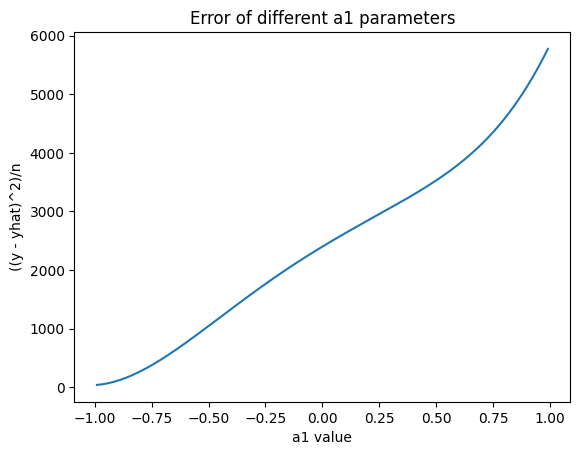

In [9]:
# Using data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1_ls = np.arange(-.99, 1, .01)
error_ls = []
for a in a1_ls:
    a1 = a    # Value of A1 parameter
    A = np.array([[-a1, 0, 0], [1, 0, 0], [0, 1, 0]])
    Re = 50 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
    Rw = 100    # How noisy the estimate will be

    Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
    xtt1 = np.array([0]*3)    # Set initial states as 0

    Xsave = np.zeros((3, N))
    ehat = np.zeros(N)
    yhat = np.zeros(N)

    for t in range(0, N):
        Ct = np.array([1,1,1]).reshape(1, -1)
        Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
        Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
        yhat[t] = np.dot(Ct, xtt1).item()

        ehat[t] = y[t] - yhat[t]
        Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
        Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

        xtt1 = np.dot(A, Xsave[:,t])
        Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
    error = sum(np.square(np.subtract(y[:-1],yhat[1:])))/(len(y)-1)
    error_ls.append(error)

min_a1 = a1_ls[error_ls.index(min(error_ls))]
print(f'minimum value of a1 that minimizes the error is {round(min_a1, 2)}')
print(f'estimated variance of residual is {round(min(error_ls), 2)}')
plt.plot(a1_ls, error_ls)

plt.title('Error of different a1 parameters')
plt.xlabel('a1 value')
plt.ylabel('((y - yhat)^2)/n')
plt.show()


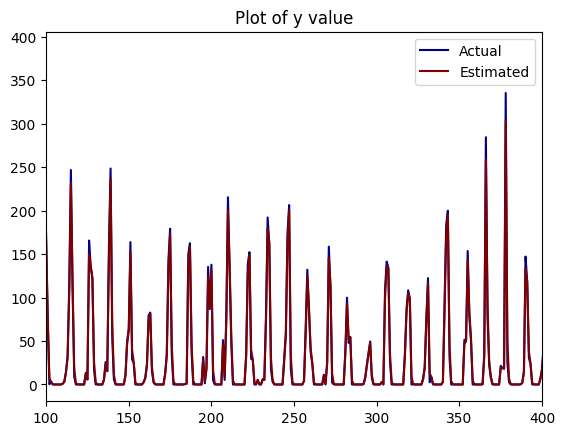

In [10]:
# Using log transformed data perform kalman gain to get the AR(1) coefficient
N = len(y)
a1 = min_a1   # Value of A1 parameter
A = np.array([[-a1, 0, 0], [1, 0, 0], [0, 1, 0]])
Re = 50 * np.eye(3)   #   How fast changes of estimates are reflected. Since y_t = x_t + x_t-1 + x_t-2 exactly, we have to use big values of Re to see this.
Rw = 100    # How noisy the estimate will be

Rxx1 = 10 * np.eye(3)    # How confident we are with initial states
# xtt1 = np.array([y[0]/3]*3)    # Set initial states as the first value of rain/3
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave = np.zeros((3, N))
ehat = np.zeros(N)
yhat = np.zeros(N)

for t in range(0, N):
    Ct = np.array([1,1,1]).reshape(1, -1)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    yhat[t] = np.dot(Ct, xtt1).item()

    ehat[t] = y[t] - yhat[t]
    Xsave[:,t] = xtt1 + np.dot(Kt, ehat[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)

    xtt1 = np.dot(A, Xsave[:,t])
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
# Plot the estimated y with actual y
x_val = []
for i in range(len(Xsave[0])):
    x_val += [Xsave[0][i], Xsave[1][i], Xsave[2][i]]
plt.plot(y[:-1], color='darkblue', label='Actual')
plt.plot(yhat[1:], color='maroon', label='Estimated')
plt.xlim(100, 400)
plt.title('Plot of y value')
plt.legend()
plt.show()

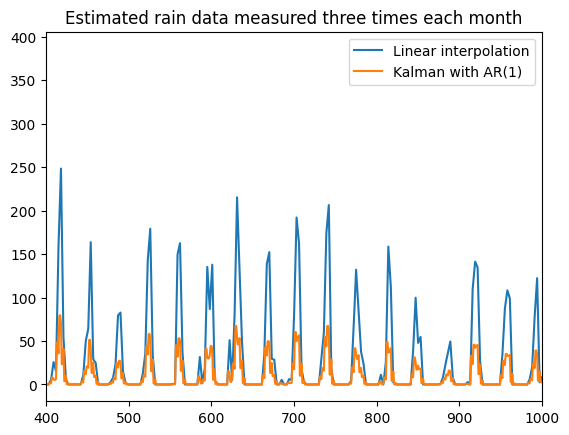

In [11]:
# Plot the estimated rain with its linear interpolated
plt.plot(ElGeneina['rain'], label='Linear interpolation')
plt.plot(x_val[1:], label='Kalman with AR(1)')
plt.title('Estimated rain data measured three times each month')
plt.xlim(400,1000)
plt.legend()
plt.show()

In [12]:
print(f"There is a difference of {round(ElGeneina['rain_org'].sum() - sum(x_val),4)} mm of total rain")
print(f"There is a difference of {round(min(error_ls), 2)} mm of rain per month")

There is a difference of 31.145 mm of total rain
There is a difference of 41.73 mm of rain per month


### Test Q1 with Simulated Data

Standard deviation of y error: 4.1982


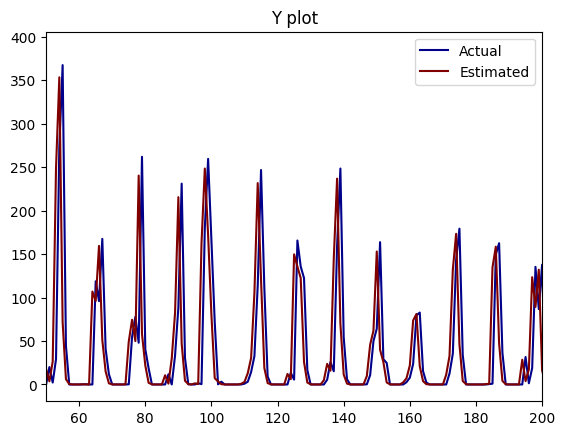

Standard deviation of x error: 1.3252


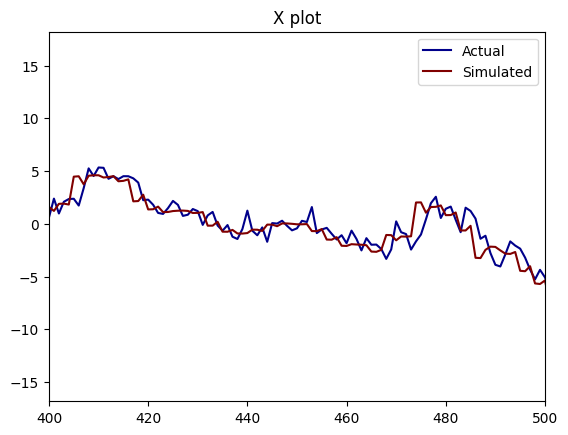

In [20]:
# Test with simulated data
test = modelling.simulateARMA(AR=[1, min_a1], size=800)
test = test[50:]
y_test = [test[i]+test[i+1]+test[i+1] for i in range(0, len(test),3)]
N_test = len(y_test)
Rxx1 = 100 * np.eye(3)    # How confident we are with initial states
xtt1 = np.array([0]*3)    # Set initial states as 0

Xsave_test = np.zeros((3, N_test))
ehat_test = np.zeros(N_test)
yhat_test = np.zeros(N_test)

for t in range(0, N_test):
    Ct = np.array([1,1,1]).reshape(1, -1)
    Ryy = np.dot(np.dot(Ct, Rxx1), Ct.T) + Rw
    Kt = np.dot(np.dot(Rxx1, Ct.T), np.linalg.inv(Ryy))
    yhat_test[t] = np.dot(Ct, xtt1).item()
    
    ehat_test[t] = y_test[t] - yhat_test[t]
    Xsave_test[:,t] = xtt1 + np.dot(Kt, ehat_test[t]).T
    Rxx = Rxx1 - np.dot(np.dot(Kt, Ryy), Kt.T)
    
    xtt1 = np.dot(A, Xsave_test[:,t])
    Rxx1 = np.dot(np.dot(A, Rxx), A.T) + Re
    
# Plot the estimated x and y
x_val_test = []
for i in range(len(Xsave_test[0])):
    x_val_test += [Xsave_test[0][i], Xsave_test[1][i], Xsave_test[2][i]]

print(f'Standard deviation of y error: {round(np.sqrt(sum(np.square(yhat_test[2:] - y_test[:-2]))/len(yhat_test[2:])),4)}')
plt.plot(y[:-2], color='darkblue', label='Actual')
plt.plot(yhat[2:], color='maroon', label='Estimated')
plt.xlim(50, 200)
plt.title('Y plot')
plt.legend()
plt.show()
plt.figure()
print(f'Standard deviation of x error: {round(np.sqrt(sum(np.square(x_val_test[3:] - test[:-3]))/len(x_val_test[3:])),4)}')
plt.plot(test[:], color='darkblue', label='Actual')
plt.plot(x_val_test[3:], color='maroon', label='Simulated')
plt.xlim(400,500)
plt.title('X plot')
plt.legend()
plt.show()

# Modeling and validation for El-Geneina

In [21]:
ElGeneina['estimated_rain'] = x_val[1:] + [0]
ElGeneina_df = ElGeneina[~np.isnan(ElGeneina['nvdi_t'])]
ElGeneina_df.tail(10)

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t,estimated_rain
638,179.0,1999.736111,32.533333,1977.736111,NaN,NaN,1.635392
639,173.9,1999.763889,16.266667,1977.763889,NaN,NaN,1.704359
640,170.3,1999.791667,0.000000,1977.791667,NaN,NaN,7.055092
641,173.1,1999.819444,0.000000,1977.819444,NaN,NaN,0.131994
642,167.2,1999.847222,0.000000,1977.847222,NaN,NaN,0.137941
643,167.9,1999.875000,0.000000,1977.875000,NaN,NaN,0.653647
644,161.9,1999.902778,0.000000,1977.902778,NaN,NaN,0.013301
645,159.2,1999.930556,0.000000,1977.930556,NaN,NaN,0.013800
646,162.4,1999.958333,0.000000,1977.958333,NaN,NaN,0.055008
647,157.3,1999.986111,0.000000,1977.986111,NaN,NaN,0.004073


We divide our data to modelling, validating, and testing

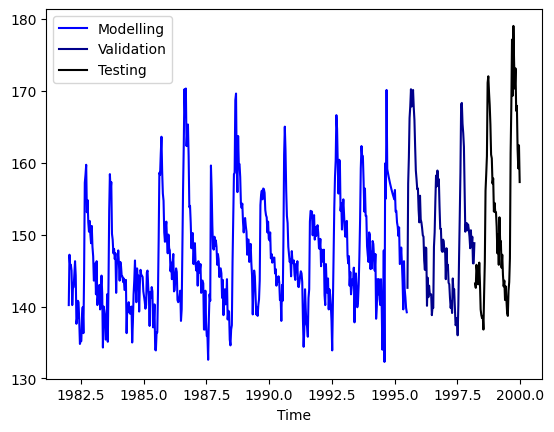

In [23]:
n_modelling = round(ElGeneina_df.shape[0] * .75)
n_validation = round(ElGeneina_df.shape[0] * .15)
n_test = round(ElGeneina_df.shape[0] * .1)
EG_modelling = ElGeneina_df.iloc[:n_modelling]
EG_validation = ElGeneina_df.iloc[n_modelling:n_modelling+n_validation]
EG_testing = ElGeneina_df.iloc[n_modelling+n_validation:]
plt.plot(EG_modelling['nvdi_t'],EG_modelling['nvdi'], color='b', label='Modelling')
plt.plot(EG_validation['nvdi_t'],EG_validation['nvdi'], color='darkblue', label='Validation')
plt.plot(EG_testing['nvdi_t'], EG_testing['nvdi'], color='black', label='Testing')
plt.legend()
plt.xlabel('Time')
plt.show()

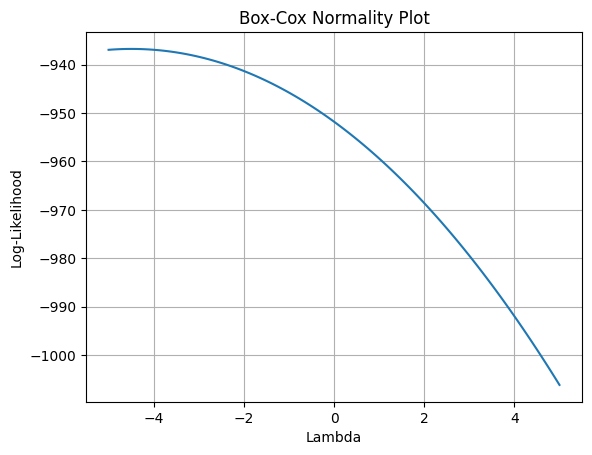

Max Lambda = -4.493315778305364.
y^-3 could be an appropriate transformation.


In [24]:
EG_nvdi = EG_modelling['nvdi'].values
max_lambda = analysis.box_cox(EG_nvdi, lamRange=[-5,5])

Here we will be using $y^{-1}$ as there isn't much difference in the log-likelihood, a bigger transformation will also lead to more errors during the modelling phase.

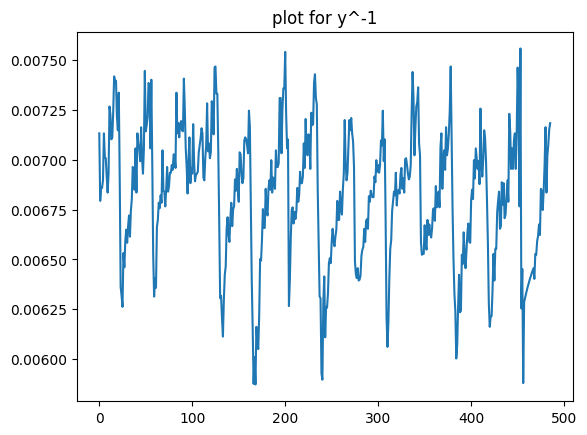

In [25]:
# We try plotting for y^-1
transformed_EG_nvdi = [i**-1 for i in EG_nvdi]
plt.plot(transformed_EG_nvdi)
plt.title('plot for y^-1')
plt.show()

## Without percipitation

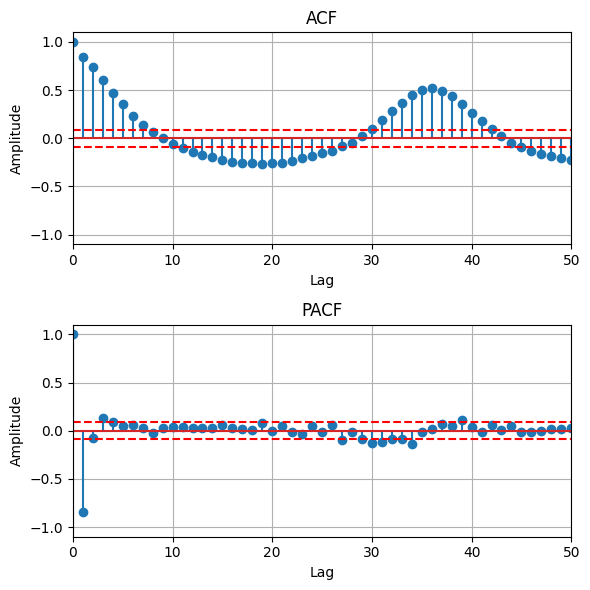

In [26]:
modelling.plotACFnPACF(transformed_EG_nvdi, noLags=50)

Here we observe a season of 36, we will first get rid of this

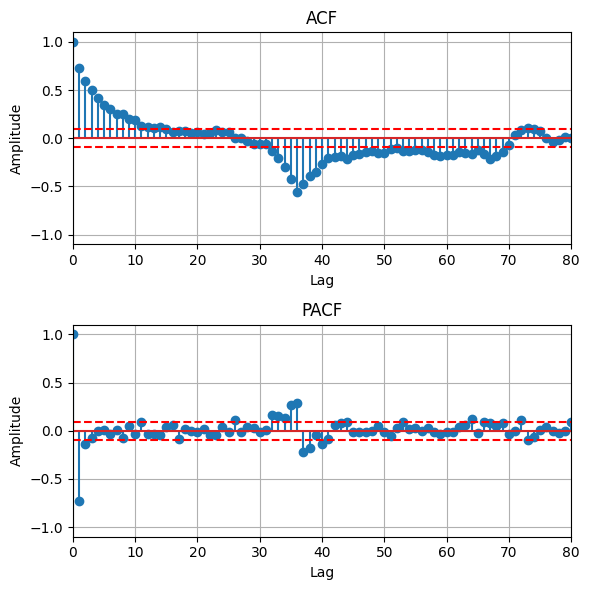

In [27]:
AS = [1] + [0]*35 + [-1]
EG_nvdi_nabla36 = modelling.filter(AS,1,transformed_EG_nvdi, remove=True)
modelling.plotACFnPACF(EG_nvdi_nabla36, noLags=80)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.73(±0.0322)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 31.5%
FPE : 0.0  MSE : 0.0
AIC : -6353.98   BIC : -6349.873



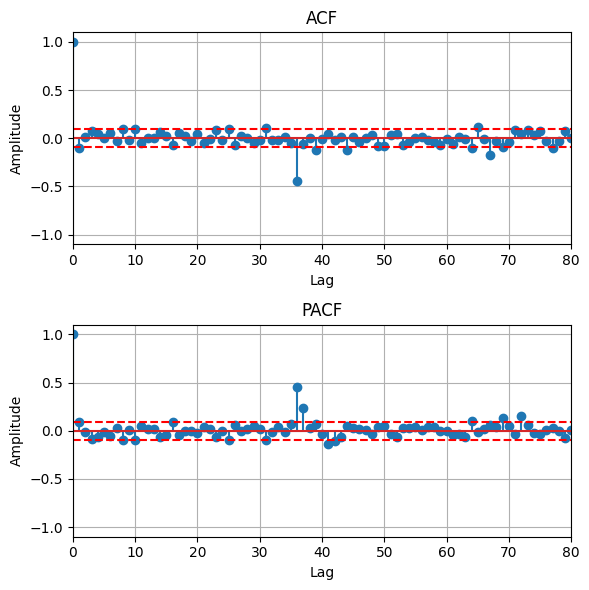

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 28.17 < 31.41)
  McLeod-Li test:        False (white if 102.03 < 31.41)
  Monti test:            True (white if 27.13 < 31.41)
  Sign change test:      True (white if 0.53 in [0.45,0.55])


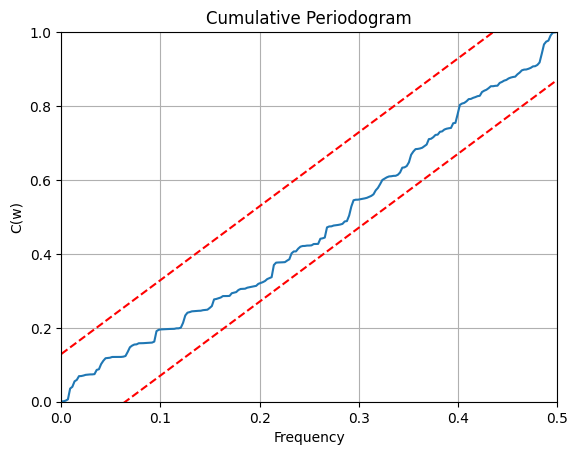

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


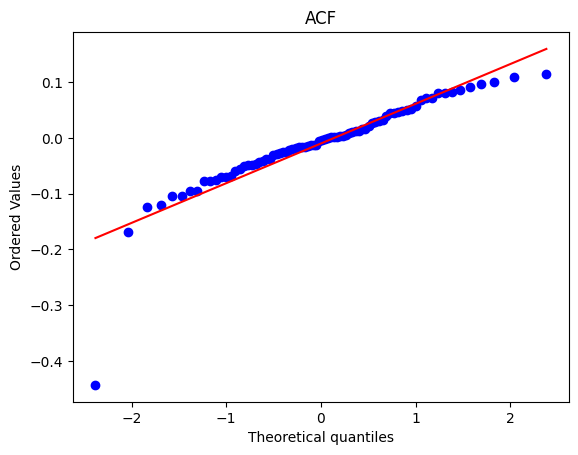

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


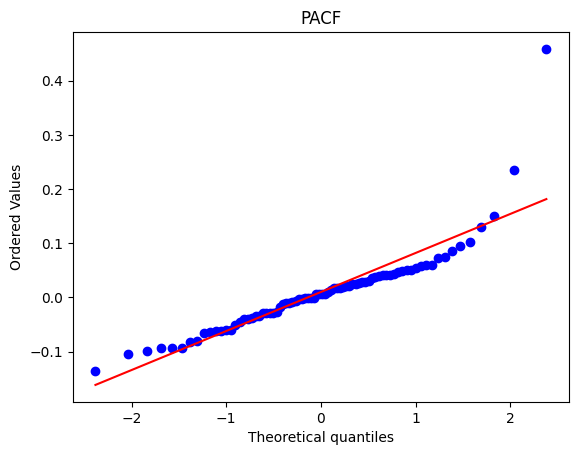

In [28]:
# Here we try to model an AR(1)
AS = 1
model_ar, ACF_ar, PACF_ar = analyzeARMA(EG_nvdi_nabla36, A=AS,noLags=80, return_val=True)

Here $c_{36}$ seems reasonable as we are done with the a parameters. We try to give it a $c_{36}$ parameter

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 - 0.7432(±0.0358)·z⁻³⁶

Polynomial orders: nC = 36
Number of free coefficients: 1
Fit to estimation data (NRMSE): 17.55%
FPE : 0.0  MSE : 0.0
AIC : -6527.507   BIC : -6523.4



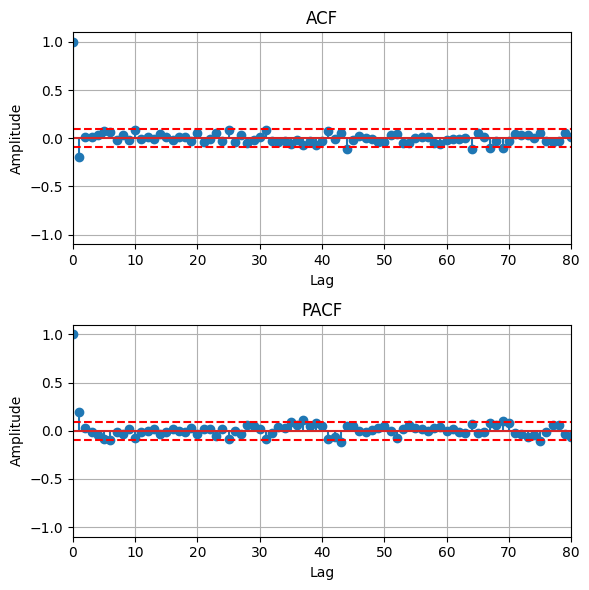

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 29.73 < 31.41)
  McLeod-Li test:        False (white if 116.11 < 31.41)
  Monti test:            True (white if 30.95 < 31.41)
  Sign change test:      True (white if 0.53 in [0.45,0.55])


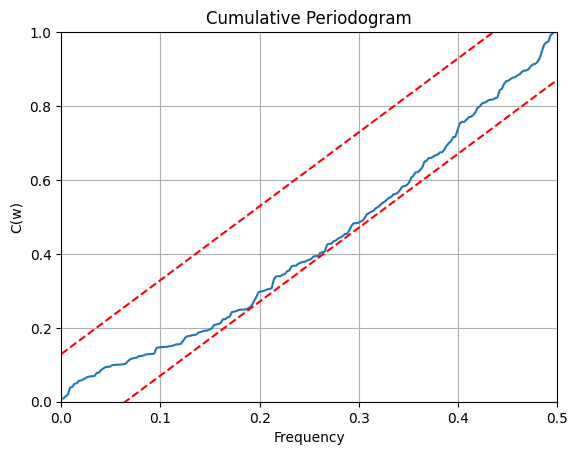

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


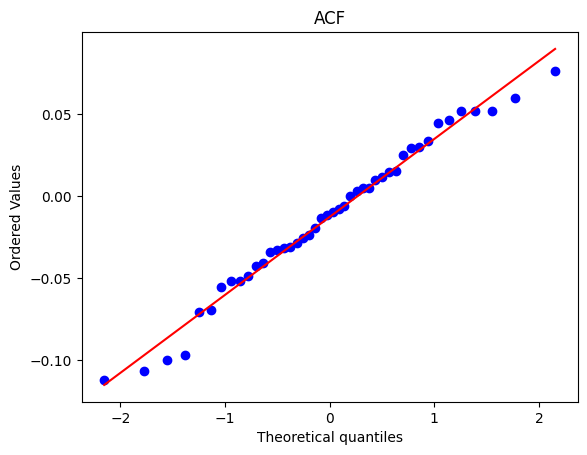

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


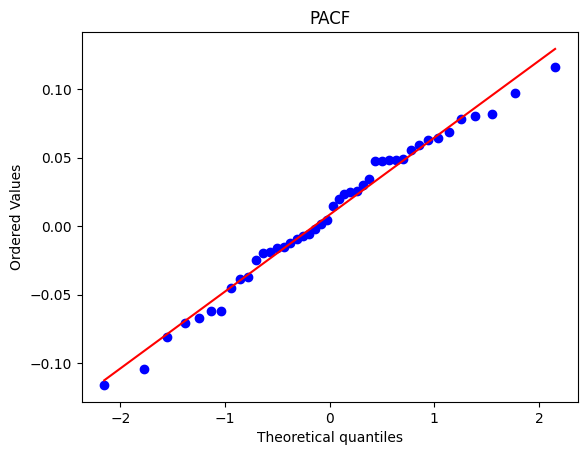

In [29]:
CS = [1] + [0]*35 + [1]
model_ma, ACF_ma, PACF_ma = analyzeARMA(model_ar.resid, C=CS,noLags=80, return_val=True)

Here we see that our error is reasonably normal based on our tests (it satisfies the cumulative periodogram test and the Monti-test, and that the ACF and PACF are reasonably normal). Now we re-estimate all the parameters together.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.9996(±0.0013)·z⁻¹ + 2.498(±4.4555)·z⁻³⁶ - 2.4971(±4.4534)·z⁻³⁷
C(z) = 1.0 + 2.498(±4.4555)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 4
Fit to estimation data (NRMSE): 45.23%
FPE : 0.0  MSE : 0.0
AIC : -6469.49   BIC : -6453.062



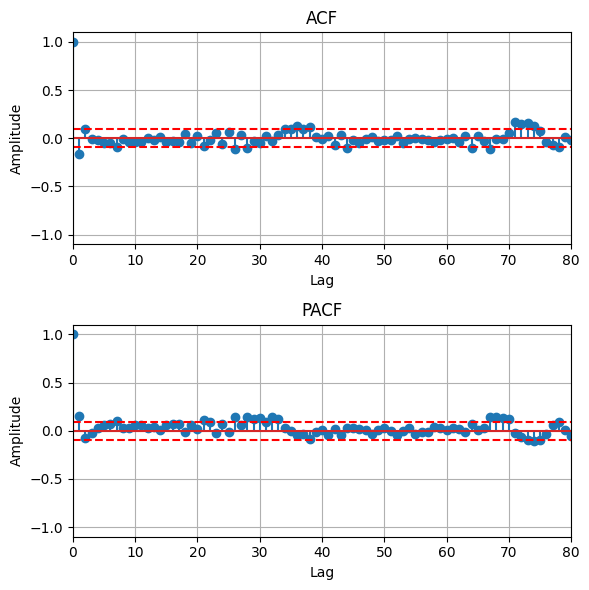

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 28.83 < 31.41)
  McLeod-Li test:        False (white if 82.82 < 31.41)
  Monti test:            False (white if 36.21 < 31.41)
  Sign change test:      False (white if 0.55 in [0.45,0.55])


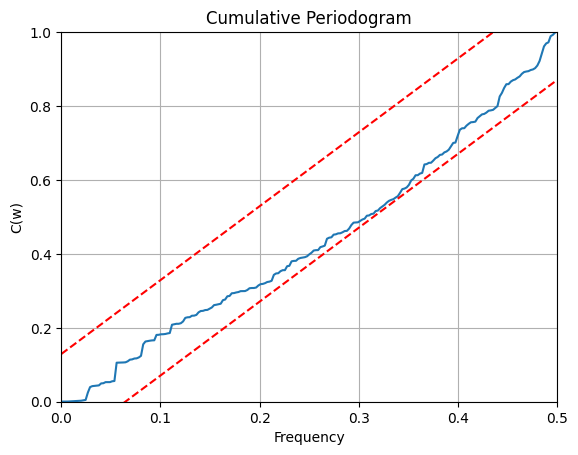

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


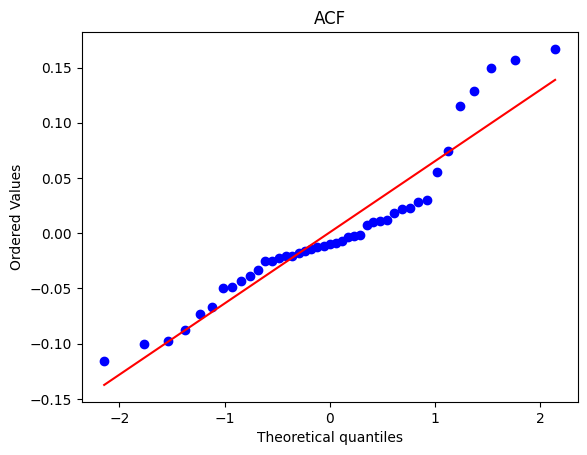

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


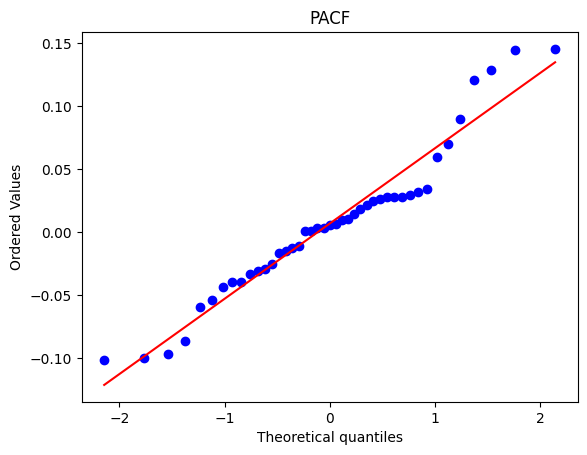

In [30]:
AS = [1, 1] + [0]*34 + [1,1]
CS = [1] + [0]*35 + [1]
model_full_tr, ACF_full_tr, PACF_full_tr = analyzeARMA(transformed_EG_nvdi, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Since the ACF and PACF is not normally distributed, the whiteness tests cannot be trusted, and since we observe a value very close to the significant level for the Monti test, along with the cumulative periodogram, we can say that the residuals are more or less white.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8302(±0.0266)·z⁻¹ - 0.3144(±0.0545)·z⁻³⁶ + 0.144(±0.0562)·z⁻³⁷
C(z) = 1.0 - 0.032(±0.0253)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 4
Fit to estimation data (NRMSE): 49.54%
FPE : 13.437  MSE : 13.2
AIC : 2440.725   BIC : 2457.153



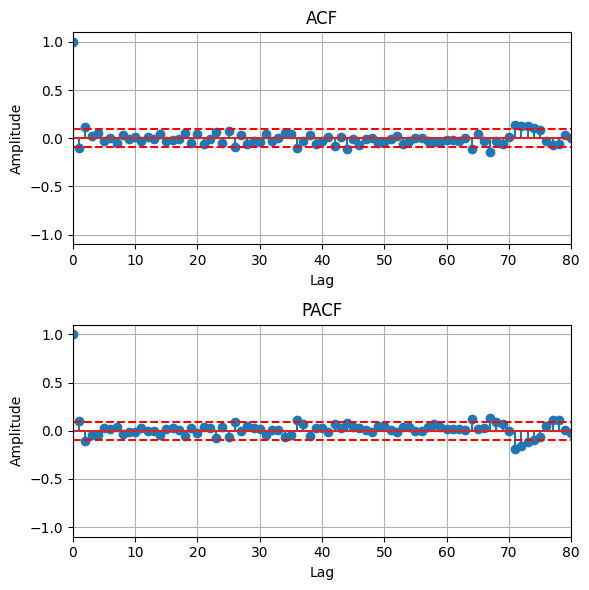

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.65 < 31.41)
  McLeod-Li test:        False (white if 139.83 < 31.41)
  Monti test:            True (white if 17.54 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


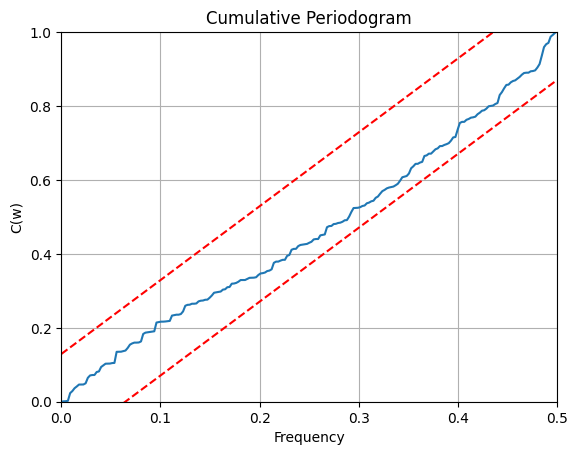

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


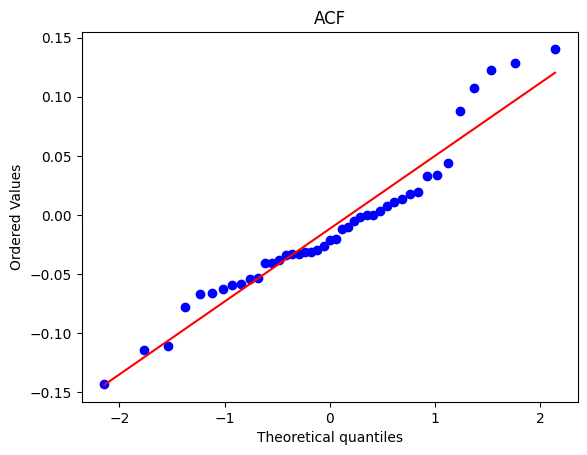

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


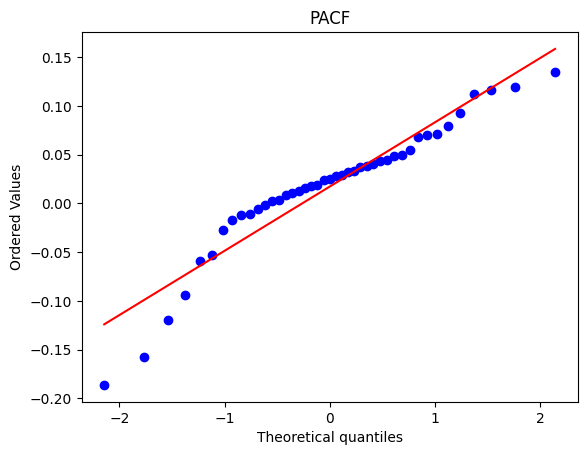

In [31]:
# Modelling with the same parameters for untransformed data. Note that I have already checked for the optimal 
# parameters the same way for the transformed data.
AS = [1, 1] + [0]*34 + [1,1]
CS = [1] + [0]*35 + [1]
model_full, ACF_full, PACF_full = analyzeARMA(EG_nvdi, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Hence, we take our estimated ARMA coefficients and form our prediction in our validation data.

### Prediction on Validation data

The naive predictor that we will be using here would be the rain data from the latest year ago, or 36 indexes away. 

Estimate noise variance for naive predictor is 52.985


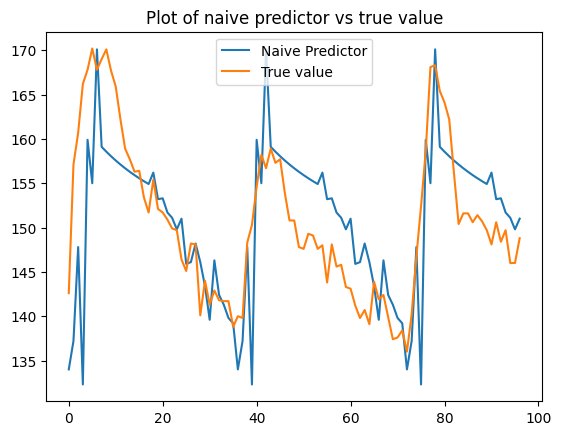

In [32]:
y = EG_validation['nvdi'].values
n = int(np.ceil(len(y)/36))
naive_pred = EG_nvdi[-36:].tolist()*n
naive_pred = naive_pred[:len(y)-len(naive_pred)]
pred_error = y[len(y)-len(naive_pred):] - np.array(naive_pred)
noise_var = np.var(pred_error)
print(f'Estimate noise variance for naive predictor is {round(noise_var,4)}')
plt.plot(naive_pred, label='Naive Predictor')
plt.plot(y, label='True value')
plt.title('Plot of naive predictor vs true value')
plt.legend()
plt.show()

Estimate noise variance for 1-step prediction is 10.2473
Estimate noise variance for 7-step prediction is 124.8853


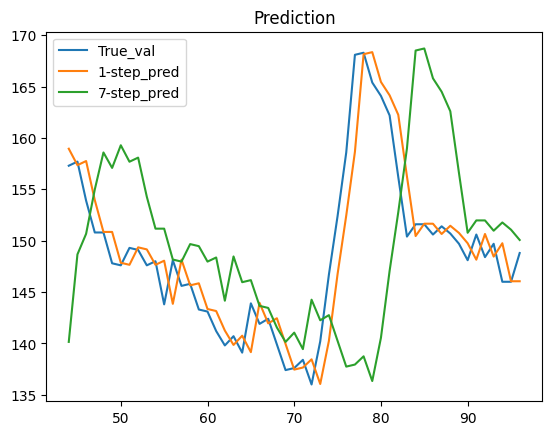

In [33]:
# Transformed prediction
yhat_k, noise_k = pred_k(y=y, k=[1,7], A=model_full_tr.A, C=model_full_tr.C, transform=lambda x: (x**-1), inv_transform=lambda x: (x**-1))

Estimate noise variance for 1-step prediction is 7.2705
Estimate noise variance for 7-step prediction is 37.746


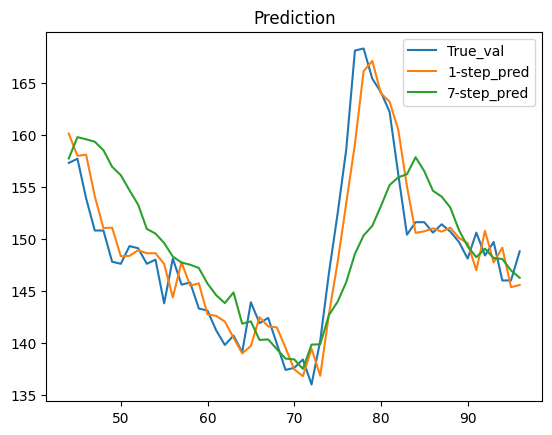

In [34]:
y = EG_validation['nvdi'].values
yhat_k, noise_k = pred_k(y=y, k=[1,7], A=model_full.A, C=model_full.C)

Here we see that the transformed prediction follows the actual data better, but a smaller noise variance is observed for the untransformed data. We also observe that the transformed and untransformed prediction has a smaller noise variance than the naive prediction.

#### Test prediction

Estimate noise variance is 0.375095


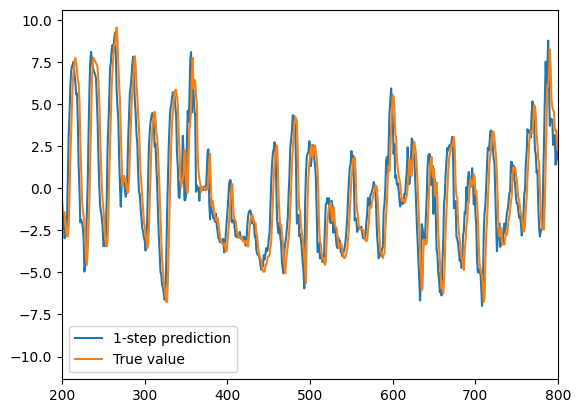

In [141]:
svedala = analysis.mat2np('./data/svedala.mat')
A = [1, -1.79, 0.84] ;
C = [1, -0.18, -0.11 ] ;
k = 1
yhat_k, noise_var = pred_k(svedala, A=A,C=C,s=0,k=1)
# pred_error = svedala[len(svedala)-len(yhat_k):] - yhat_k
# noise_var = np.var(pred_error)
print(f'Estimate noise variance is {round(noise_var,6)}')
plt.plot(yhat_k, label='1-step prediction')
plt.plot(svedala, label='True value')
plt.xlim(200, 800)
plt.legend()
plt.show()

## With precipitation

In [76]:
EG_modelling

,nvdi,nvdi_t,rain,rain_t,rain_org,rain_org_t,estimated_rain
0,140.2,1982.013889,0.000000,1960.013889,0.0,1960.041667,0.000769
1,147.2,1982.041667,0.000000,1960.041667,0.0,1960.125000,0.000769
2,145.7,1982.069444,0.000000,1960.069444,0.0,1960.208333,0.002535
3,145.8,1982.097222,0.000000,1960.097222,0.0,1960.291667,0.002547
4,145.0,1982.125000,0.000000,1960.125000,0.0,1960.375000,0.002287
...,...,...,...,...,...,...,...
481,146.3,1995.375000,7.800000,1973.375000,NaN,NaN,1.960169
482,142.4,1995.402778,13.066667,1973.402778,NaN,NaN,7.310154
483,141.3,1995.430556,18.333333,1973.430556,NaN,NaN,7.368744
484,139.8,1995.458333,23.600000,1973.458333,NaN,NaN,5.911707


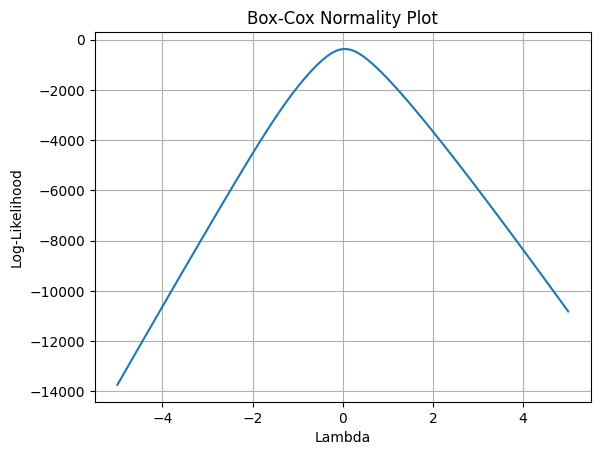

Max Lambda = 0.04653825480931217.
ln(y) could be an appropriate transformation.


In [85]:
max_lambda = analysis.box_cox(EG_modelling['estimated_rain'].values, lamRange=[-5,5])

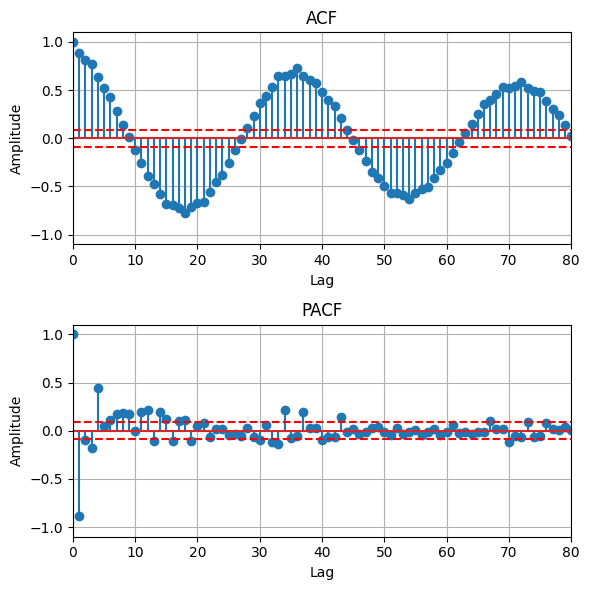

In [35]:
x = np.log(EG_modelling['estimated_rain'].values)
analysis.plotACFnPACF(x, noLags=80)

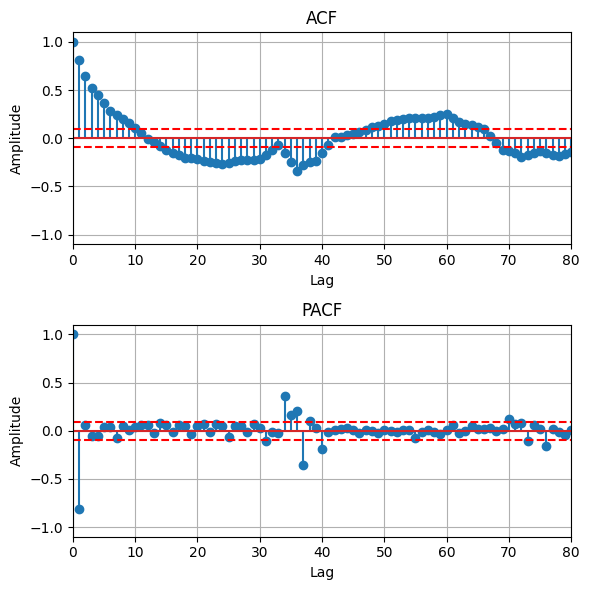

In [36]:
AS = [1] + [0]*35 + [-1]
x_nabla36 = modelling.filter(AS,1,x, remove=True)
modelling.plotACFnPACF(x_nabla36, noLags=80)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.8143(±0.0273)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 41.98%
FPE : 1.973  MSE : 1.964
AIC : 1579.282   BIC : 1583.389



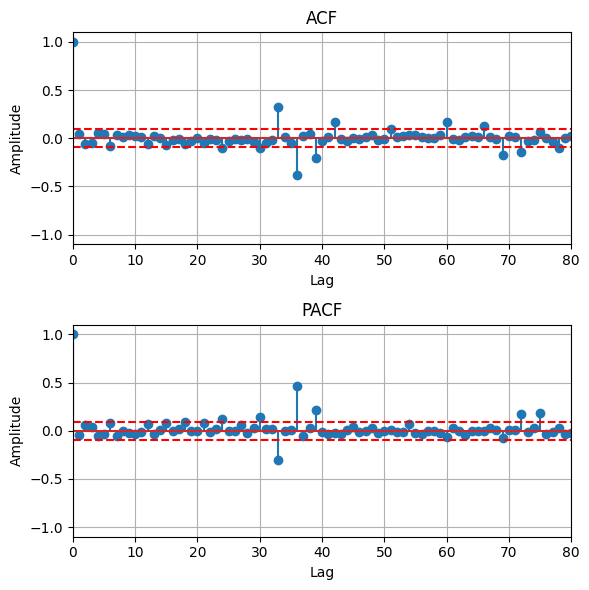

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 16.67 < 31.41)
  McLeod-Li test:        False (white if 107.24 < 31.41)
  Monti test:            True (white if 19.93 < 31.41)
  Sign change test:      False (white if 0.42 in [0.45,0.55])


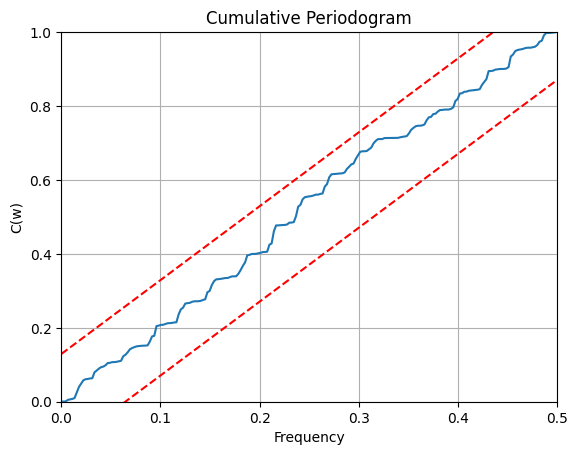

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


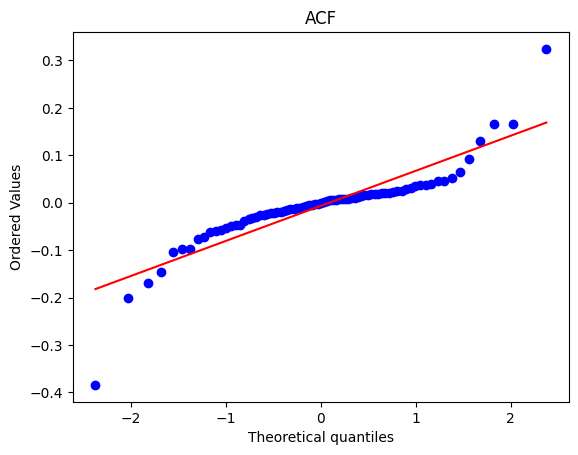

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


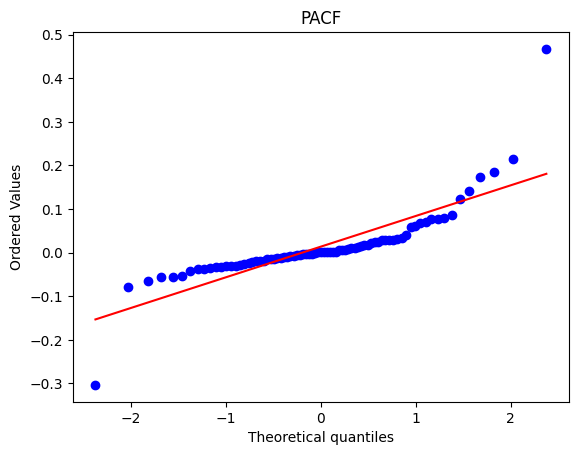

In [37]:
# Here we try to model an AR(1)
AS = [1, 1]
model_x_ar, ACF_x_ar, PACF_x_ar = analyzeARMA(x_nabla36, A=AS,noLags=80, return_val=True)

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 + 0.1893(±0.0344)·z⁻³³ - 0.6657(±0.0344)·z⁻³⁶

Polynomial orders: nC = 36
Number of free coefficients: 2
Fit to estimation data (NRMSE): 18.44%
FPE : 1.318  MSE : 1.306
AIC : 1398.224   BIC : 1406.438



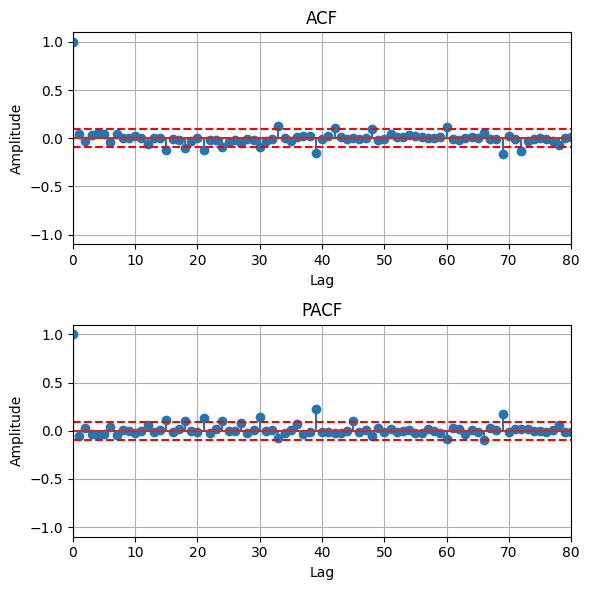

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.35 < 31.41)
  McLeod-Li test:        False (white if 95.14 < 31.41)
  Monti test:            True (white if 19.88 < 31.41)
  Sign change test:      True (white if 0.46 in [0.45,0.55])


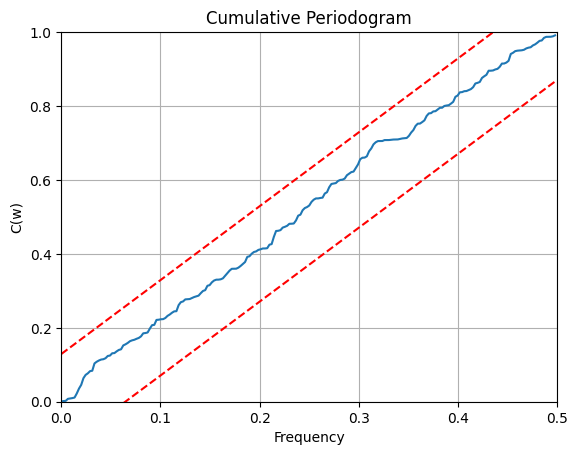

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


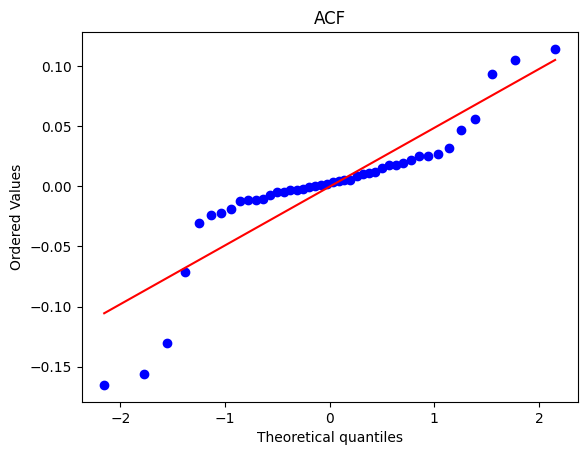

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


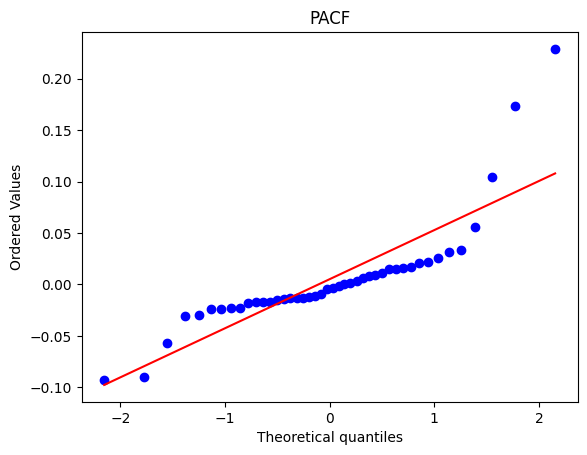

In [39]:
# Including a c_33 and c_36
CS = [1] + [0]*32 + [1, 0,0 ,1]
model_x_ma, ACF_x_ma, PACF_x_ma = analyzeARMA(model_x_ar.resid, C=CS,noLags=80, return_val=True)

Seems reasonable. Now re-estimating all the parameters together

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8443(±0.0254)·z⁻¹ - 0.893(±0.0326)·z⁻³⁶ + 0.749(±0.037)·z⁻³⁷
C(z) = 1.0 + 0.2533(±0.0357)·z⁻³³ - 0.5369(±0.0499)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 5
Fit to estimation data (NRMSE): 69.34%
FPE : 1.328  MSE : 1.299
AIC : 1401.649   BIC : 1422.184



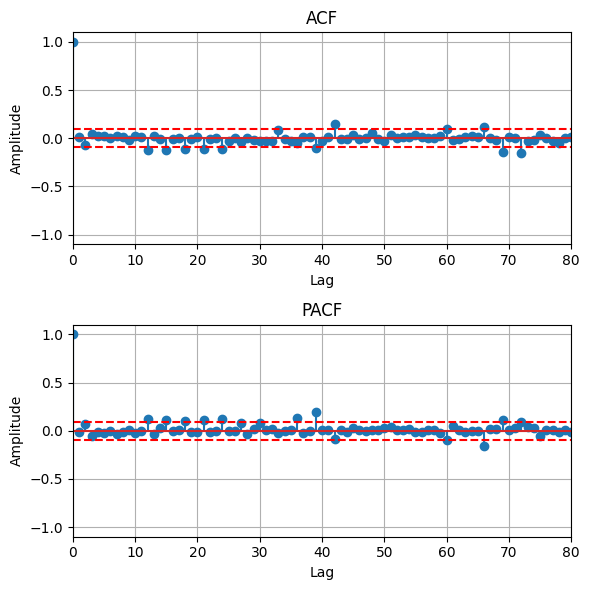

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 24.08 < 31.41)
  McLeod-Li test:        False (white if 84.47 < 31.41)
  Monti test:            True (white if 22.78 < 31.41)
  Sign change test:      False (white if 0.45 in [0.45,0.55])


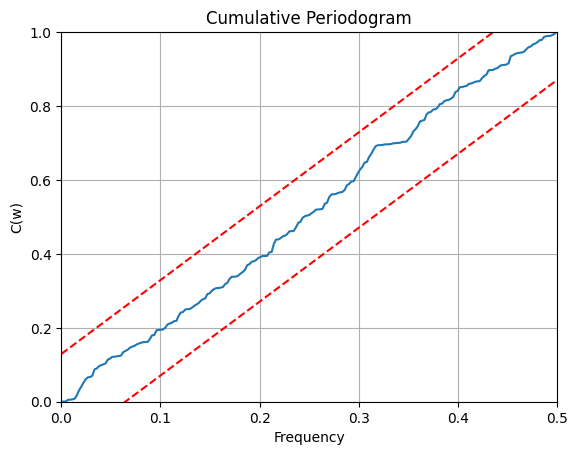

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


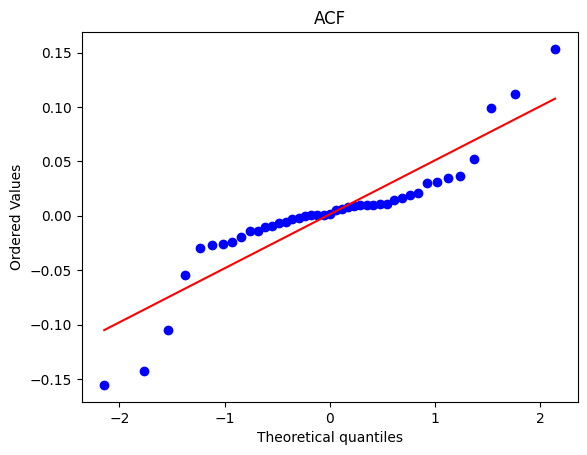

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


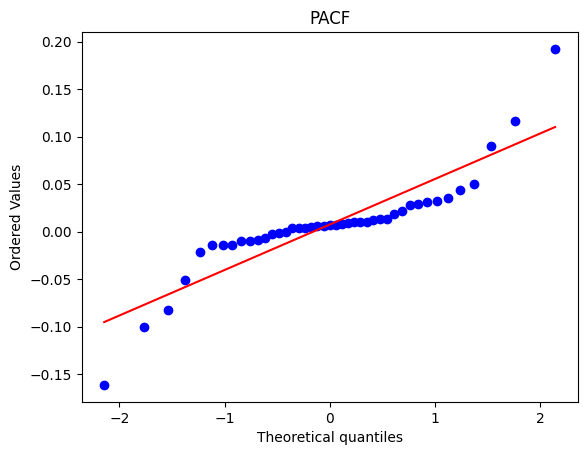

In [69]:
AS = np.convolve([1, 1], [1]  + [0]*35 + [-1])
# AS = [1,1] + [0]*34 + [1]
CS = [1] + [0]*32 + [1, 0,0 ,1]
model_x_full, ACF_x_full, PACF_x_full = analyzeARMA(x, A=AS, C=CS, noLags=80, return_val=True, remove=True)

Very reasonable

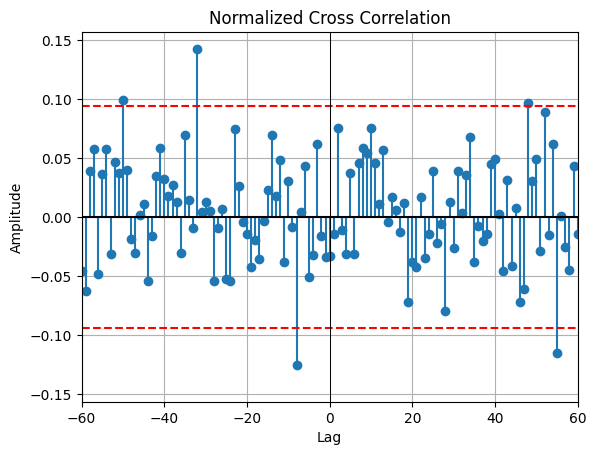

In [83]:
# Pre-whiten y_t
y = EG_modelling['nvdi'].values
est_A3 = model_x_full.A
est_C3 = model_x_full.C
w_t = model_x_full.resid
M = 80
eps_t = modelling.filter(est_A3, est_C3, y, remove=True)
corr = analysis.ccf(w_t, eps_t, numLags=60, plotIt=False)
analysis.ccf(w_t, eps_t, numLags=60)

Here, d=48 or d=55, s=0, r=0 looks reasonable

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = -5.143(±0.2546)·z⁻⁵⁵

Polynomial orders: nB = 55
Number of free coefficients: 1
Fit to estimation data (NRMSE): -1929.44%
FPE : 400.047  MSE : 21349.954
AIC : 5521.68   BIC : 5525.746



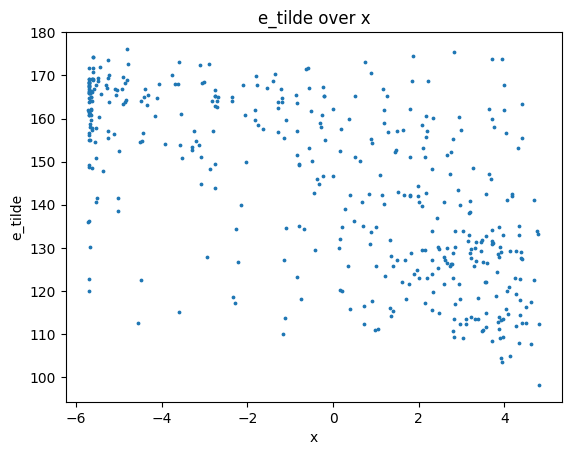

In [151]:
# Estimate 
x = np.log(EG_modelling['estimated_rain'].values)
A2 = 0
B = [0]*55 +[1]
model_x = modelling.PEM( y=y,x=x,A=0,B=B,F=A2)
model_x.set_free_params(B_free=B)
model_fitted_x = model_x.fit(method='LS', bh=False)
model_fitted_x.summary()
e_tilde = model_fitted_x.resid
plt.scatter(x[len(x)-len(e_tilde):], e_tilde, s=3)
plt.title('e_tilde over x')
plt.xlabel('x')
plt.ylabel('e_tilde')
plt.show()

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = -4.7447(±0.2808)·z⁻⁴⁸

Polynomial orders: nB = 48
Number of free coefficients: 1
Fit to estimation data (NRMSE): -1929.8%
FPE : 502.256  MSE : 21357.551
AIC : 5611.483   BIC : 5615.565



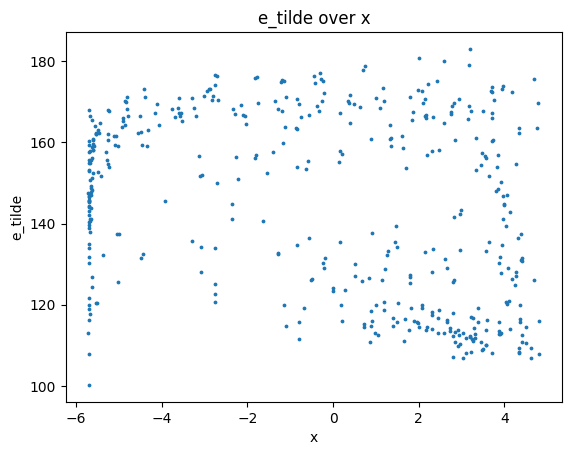

In [152]:
# Estimate 
A2 = 0
x = np.log(EG_modelling['estimated_rain'].values)
B = [0]*48 +[1]
model_x = modelling.PEM( y=y,x=x,A=0,B=B,F=A2)
model_x.set_free_params(B_free=B)
model_fitted_x = model_x.fit(method='LS', bh=False)
model_fitted_x.summary()
e_tilde = model_fitted_x.resid
plt.scatter(x[len(x)-len(e_tilde):], e_tilde, s=3)
plt.title('e_tilde over x')
plt.xlabel('x')
plt.ylabel('e_tilde')
plt.show()

d = 48 results in a more uncorrelated e_tilde over x. Hence, we will use this value

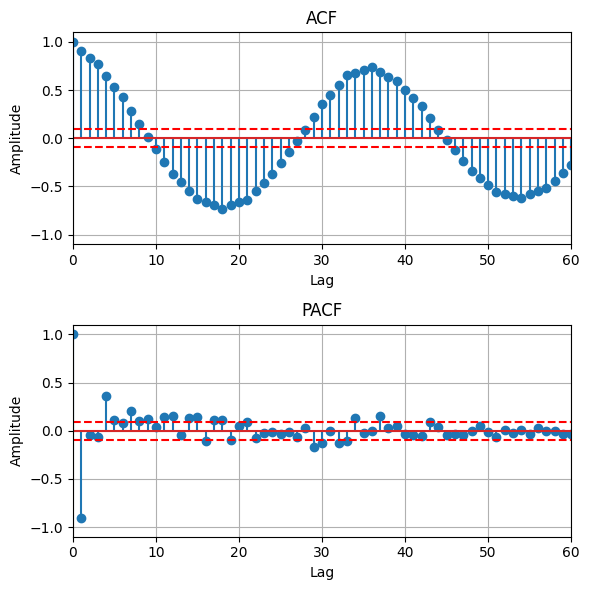

In [153]:
analysis.plotACFnPACF(e_tilde, noLags=60)

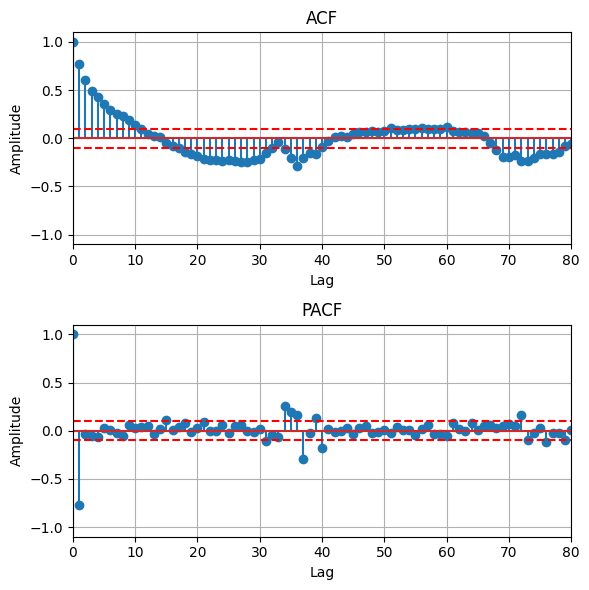

In [154]:
AS = [1] + [0]*35 + [-1]
et_nabla36 = modelling.filter(AS,1,e_tilde, remove=True)
modelling.plotACFnPACF(et_nabla36, noLags=80)

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7701(±0.0318)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 36.01%
FPE : 74.069  MSE : 73.748
AIC : 2864.55   BIC : 2868.544



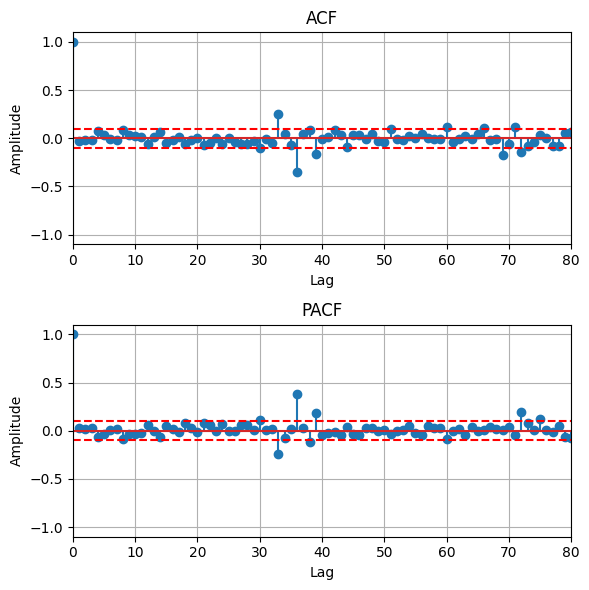

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 13.61 < 31.41)
  McLeod-Li test:        False (white if 88.20 < 31.41)
  Monti test:            True (white if 14.94 < 31.41)
  Sign change test:      True (white if 0.52 in [0.45,0.55])


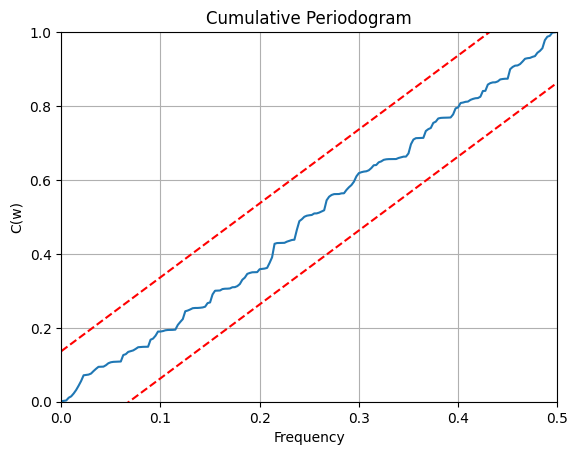

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


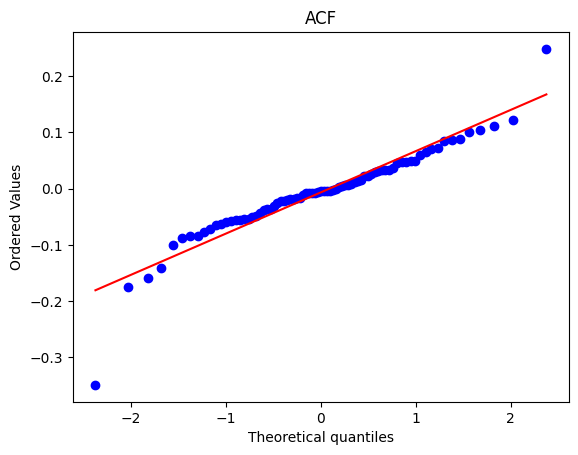

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


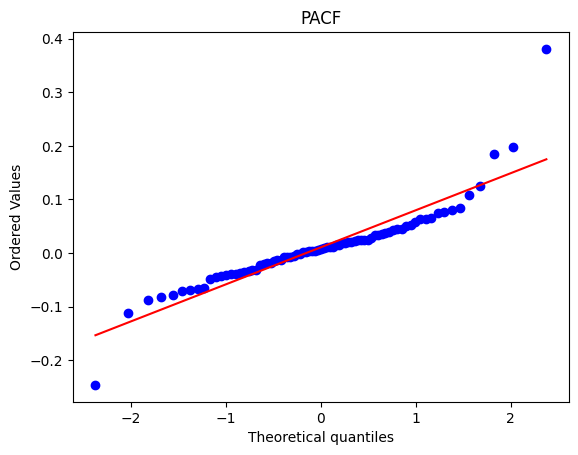

In [155]:
# Here we try to model an AR(1)
AS = [1, 1]
model_et_ar, ACF_et_ar, PACF_et_ar = analyzeARMA(et_nabla36, A=AS,noLags=80, return_val=True)

Discrete-time MA model: y(t) = C(z)e(t)

C(z) = 1.0 + 0.1201(±0.0382)·z⁻³³ - 0.6806(±0.0382)·z⁻³⁶

Polynomial orders: nC = 36
Number of free coefficients: 2
Fit to estimation data (NRMSE): 15.64%
FPE : 52.804  MSE : 52.446
AIC : 2729.865   BIC : 2737.853



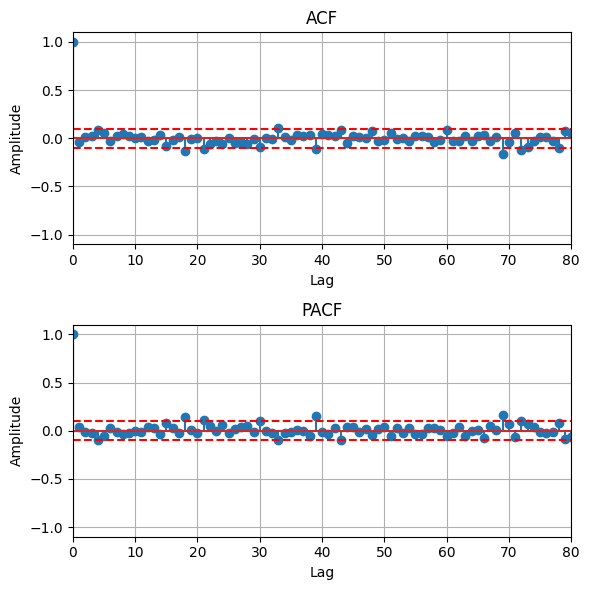

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 18.36 < 31.41)
  McLeod-Li test:        False (white if 44.82 < 31.41)
  Monti test:            True (white if 19.70 < 31.41)
  Sign change test:      True (white if 0.50 in [0.45,0.55])


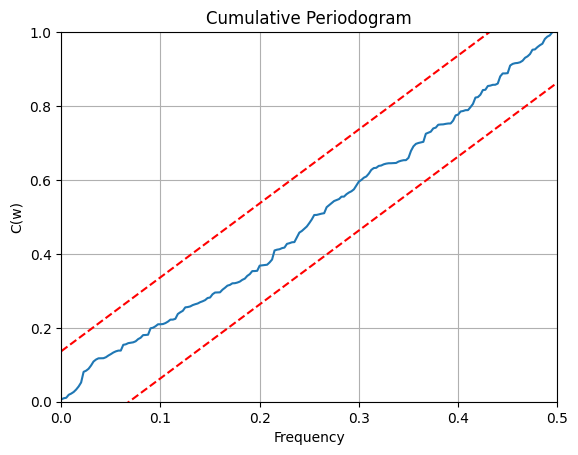

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


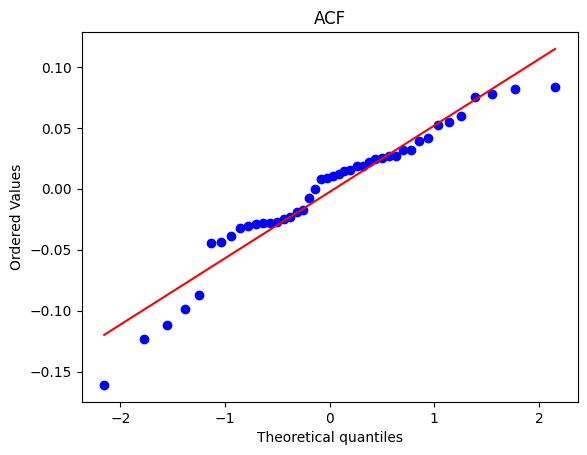

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


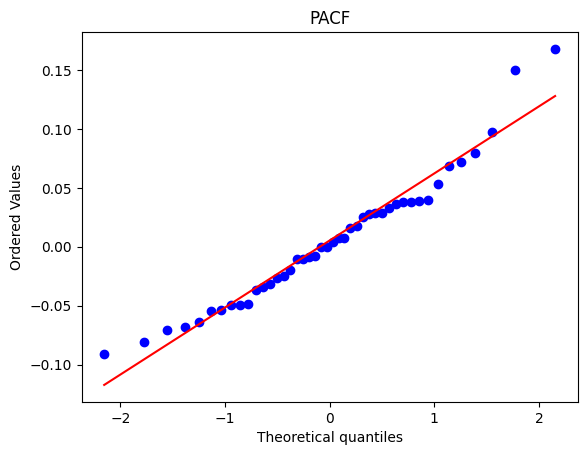

In [156]:
# Including a c_33 and c_36
CS = [1] + [0]*32 + [1, 0,0 ,1]
model_et_ma, ACF_et_ma, PACF_et_ma = analyzeARMA(model_et_ar.resid, C=CS,noLags=80, return_val=True)

Reasonable

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8302(±0.0275)·z⁻¹ - 0.7265(±0.043)·z⁻³⁶ + 0.5553(±0.0484)·z⁻³⁷
C(z) = 1.0 + 0.2693(±0.0373)·z⁻³³ - 0.3205(±0.0461)·z⁻³⁶

Polynomial orders: nA = 37    nC = 36
Number of free coefficients: 5
Fit to estimation data (NRMSE): 67.92%
FPE : 52.754  MSE : 51.461
AIC : 2728.259   BIC : 2748.229



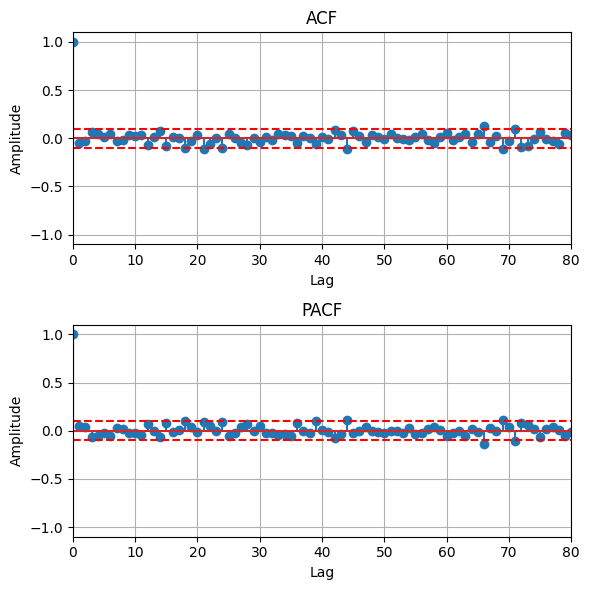

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 20.36 < 31.41)
  McLeod-Li test:        False (white if 32.58 < 31.41)
  Monti test:            True (white if 18.92 < 31.41)
  Sign change test:      True (white if 0.52 in [0.45,0.55])


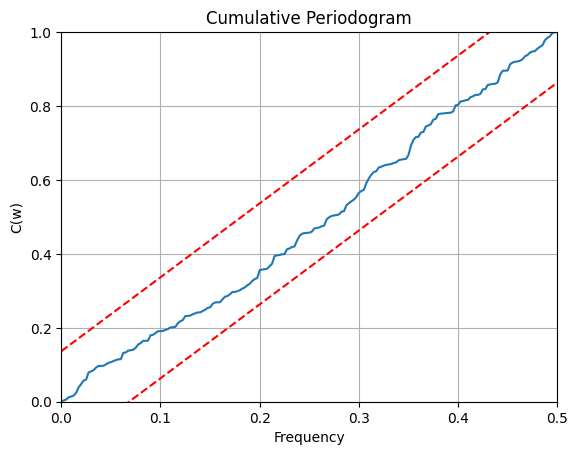

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


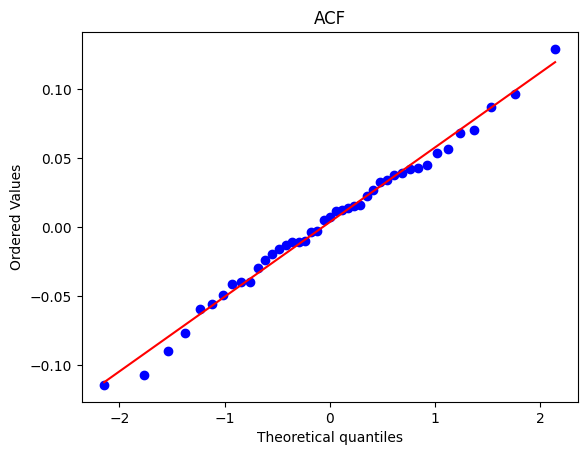

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


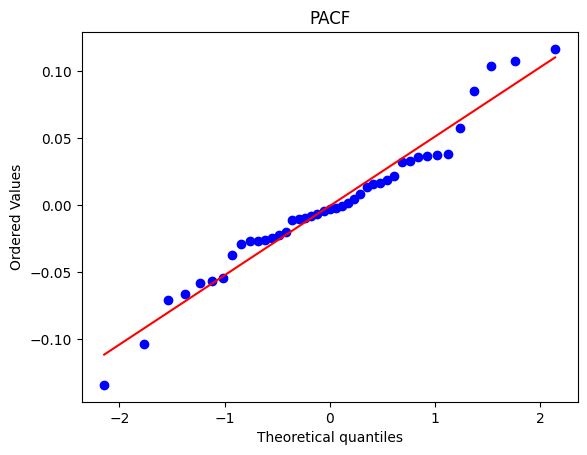

In [157]:
AS = np.convolve([1, 1], [1]  + [0]*35 + [-1])
CS = [1] + [0]*32 + [1, 0,0 ,1]
model_et_full, ACF_et_full, PACF_et_full = analyzeARMA(e_tilde, A=AS, C=CS, noLags=80, return_val=True, remove=True)

The parameter seems statistically significant as 0 is not within their confidence intervals. From the normality test of ACF and PACF, we can trust our tests more. From the whiteness test and periodogram, we can assume that the residuals are white.

Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 0.1747(±0.1184)·z⁻⁴⁸
C(z) = 1.0 + 0.0617(±0.0448)·z⁻³³ - 0.0966(±0.0485)·z⁻³⁶
D(z) = 1.0 - 0.8321(±0.0272)·z⁻¹ - 0.3763(±0.0621)·z⁻³⁶ + 0.2078(±0.0631)·z⁻³⁷

Polynomial orders: nB = 48    nC = 36    nD = 37
Number of free coefficients: 6
Fit to estimation data (NRMSE): 49.56%
FPE : 13.556  MSE : 13.19
AIC : 2384.794   BIC : 2409.288



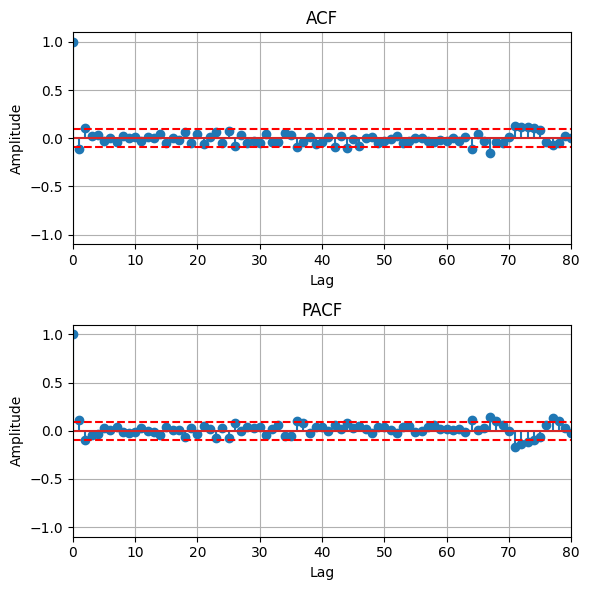

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 18.85 < 31.41)
  McLeod-Li test:        False (white if 125.52 < 31.41)
  Monti test:            True (white if 16.61 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


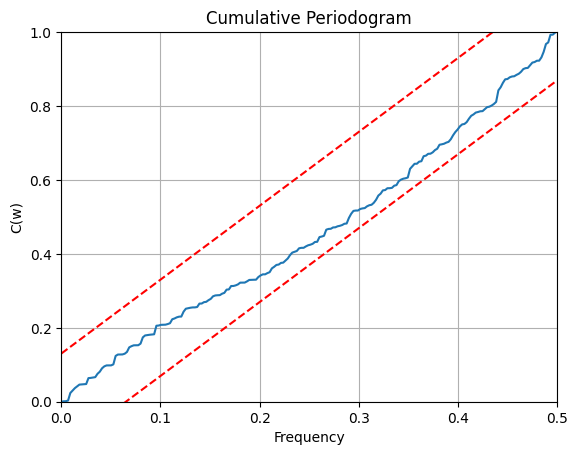

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


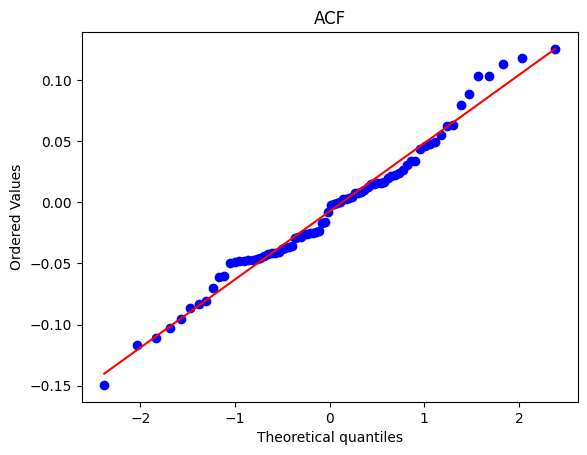

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


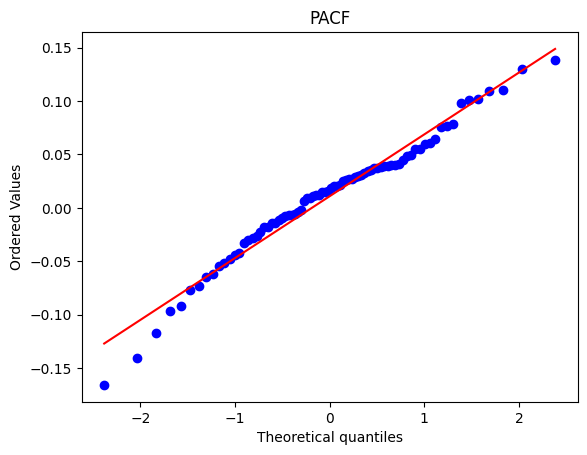

In [158]:
# Use PEM to re-estimate all parameters with the orders found
A1 = np.convolve([1, 1], [1]  + [0]*35 + [-1])
A2 = 0
B = [0]*48 + [1]
C = [1] + [0]*32 + [1, 0,0 ,1]
# C=0
final_model = modelling.PEM( y=y,x=x,A=0,B=B,F=A2, C=C, D=A1)
final_model.set_free_params(B_free=B, C_free=C, D_free=A1)
final_model_fitted = final_model.fit(method='LS', bh=False)
final_model_fitted.summary()
final_resid = final_model_fitted.resid
final_acf_est, final_pacf_est = analysis.plotACFnPACF(final_resid,noLags=80,titleStr=None, return_val=True)
tests.whiteness_test(final_resid)
checkNormal(final_acf_est, remove=1, title='ACF')
checkNormal(final_pacf_est, remove=1, title='PACF')

Here, based on the normal plot, whiteness test, and periodogram we can say that the residuals are statistically white. However, we observe that the C parameters are really close to 0, lets try to re-run this without using any C parameters.

Discrete-time BJ model: y(t) = B(z)x(t) + [1/D(z)]e(t)

B(z) = 0.1742(±0.1148)·z⁻⁴⁸
D(z) = 1.0 - 0.8407(±0.0265)·z⁻¹ - 0.2883(±0.0508)·z⁻³⁶ + 0.1288(±0.0522)·z⁻³⁷

Polynomial orders: nB = 48    nD = 37
Number of free coefficients: 4
Fit to estimation data (NRMSE): 49.37%
FPE : 13.534  MSE : 13.29
AIC : 2384.095   BIC : 2400.424



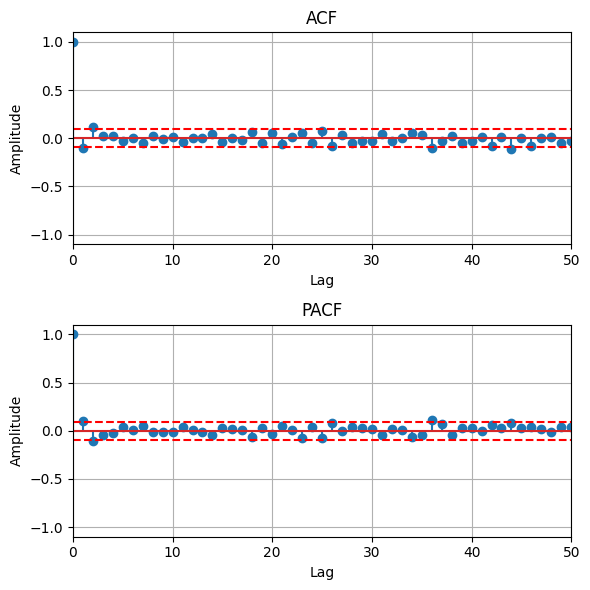

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.30 < 31.41)
  McLeod-Li test:        False (white if 126.40 < 31.41)
  Monti test:            True (white if 17.45 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


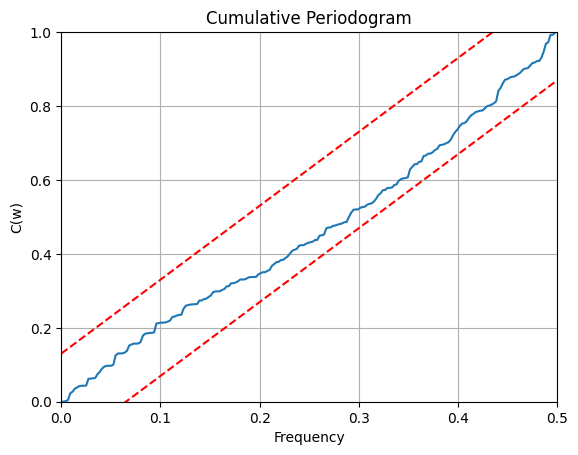

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


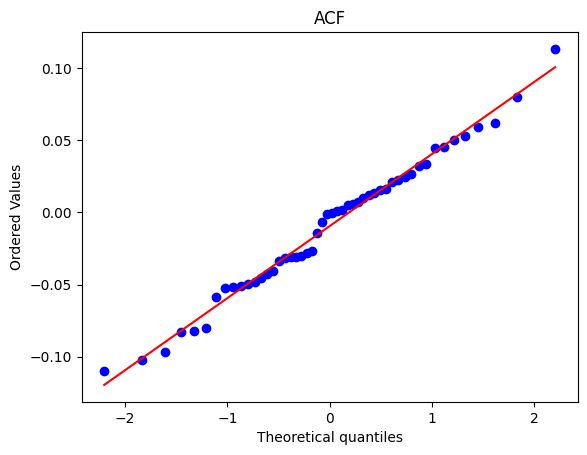

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


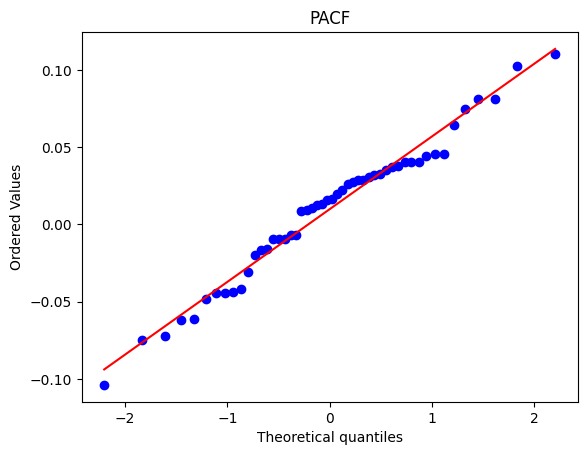

In [162]:
# Use PEM to re-estimate all parameters with the orders found with not C-parameters
x = np.log(EG_modelling['estimated_rain'].values)
y = EG_modelling['nvdi'].values
final_model = modelling.PEM( y=y,x=x,A=0,B=B,F=A2, C=0, D=A1)
final_model.set_free_params(B_free=B, D_free=A1)
final_model_fitted = final_model.fit(method='LS', bh=False)
final_model_fitted.summary()
final_resid = final_model_fitted.resid
final_acf_est, final_pacf_est = analysis.plotACFnPACF(final_resid,noLags=50,titleStr=None, return_val=True)
tests.whiteness_test(final_resid)
checkNormal(final_acf_est, remove=1, title='ACF')
checkNormal(final_pacf_est, remove=1, title='PACF')

Looks good

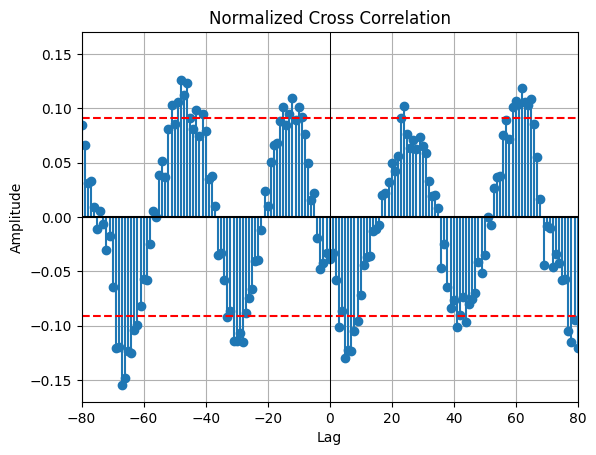

In [163]:
final_corr = analysis.ccf(x, final_resid, numLags=M, plotIt=False)
analysis.ccf(x, final_resid, numLags=M)

(100.0, 150.0)

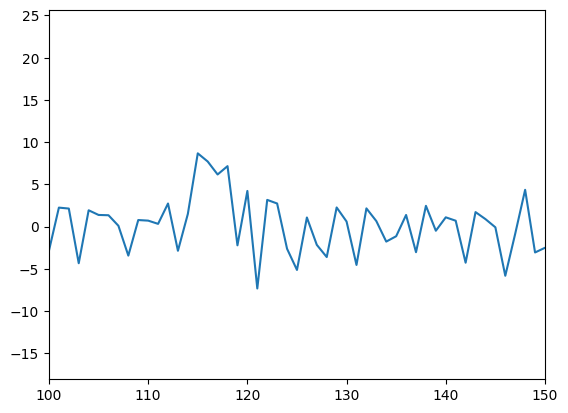

In [161]:
plt.plot(final_resid)
plt.xlim(100,150)

### Prediction on Validation data

In [164]:
np.convolve(final_model_fitted.D, final_model_fitted.F)

array([ 1.        , -0.84069274,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.28833236,  0.12877563])

In [165]:
y_v = EG_validation['nvdi'].values
x_v = np.log(EG_validation['estimated_rain'].values)
k=1
KA = np.convolve(final_model_fitted.D, final_model_fitted.F)
KB = np.convolve(final_model_fitted.D, final_model_fitted.B)
KC = np.convolve(final_model_fitted.F, final_model_fitted.C)
F1, G1 = modelling.polydiv(KC, KA, k)
BF1 = np.convolve(KB, F1)
Fhat1, Ghat1 = modelling.polydiv(BF1, KC, k)
xhat1 = modelling.filter(G1, C, x_v)

yhat1 = modelling.filter(Ghat1, C, x_v) + modelling.filter(G1, C, y_v) + modelling.filter(Fhat1, [1],x_v)
remove = max(len(Fhat1), len(Ghat1), len(G1), 1)
# yhat1 = yhat1[remove:]

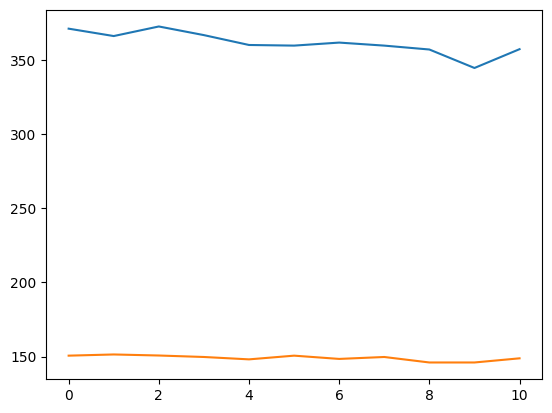

In [166]:
plt.plot(yhat1[remove:])
plt.plot(y_v[remove:])

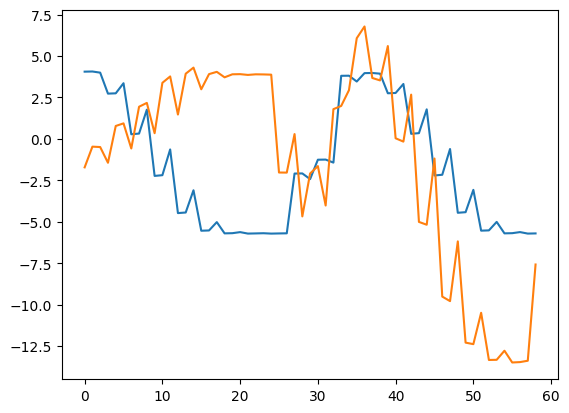

In [179]:
plt.plot(x_v[38:])
plt.plot(xhat1[38:])
# plt.plot(y_v)

In [146]:
len(yhat1)

97

Discrete-time BJ model: y(t) = [C(z)/D(z)]e(t)

C(z) = 1.0 + 0.0656(±0.0446)·z⁻³³ - 0.0937(±0.0482)·z⁻³⁶
D(z) = 1.0 - 0.8273(±0.0272)·z⁻¹ - 0.3638(±0.0618)·z⁻³⁶ + 0.1905(±0.0624)·z⁻³⁷

Polynomial orders: nC = 36    nD = 37
Number of free coefficients: 5
Fit to estimation data (NRMSE): 49.42%
FPE : 13.565  MSE : 13.26
AIC : 2390.518   BIC : 2410.941



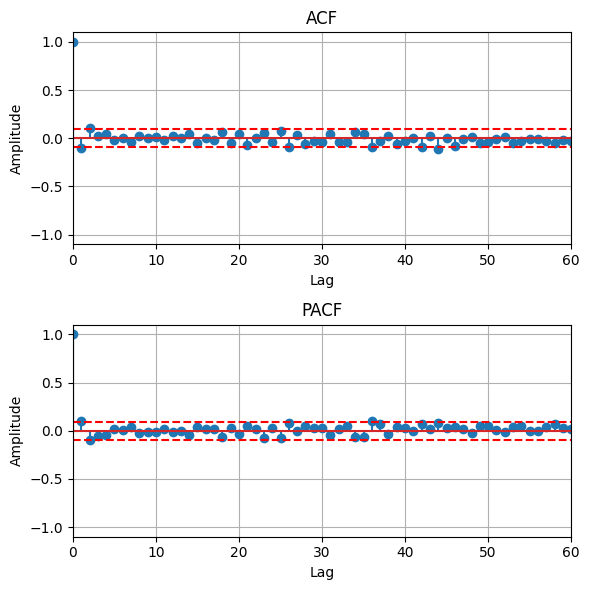

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 18.51 < 31.41)
  McLeod-Li test:        False (white if 130.99 < 31.41)
  Monti test:            True (white if 16.25 < 31.41)
  Sign change test:      True (white if 0.54 in [0.45,0.55])


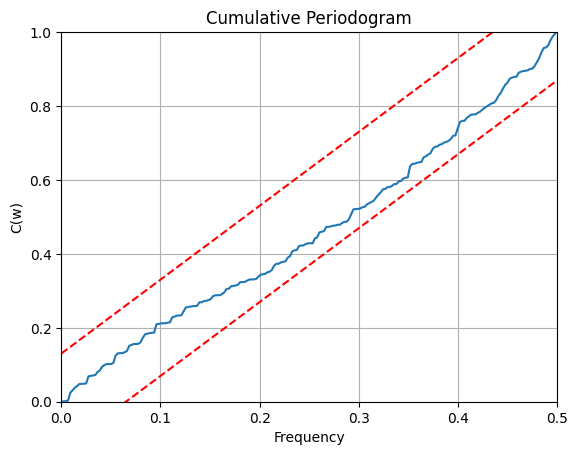

In [172]:
A1 = np.convolve([1, 1], [1]  + [0]*35 + [-1])
C = [1] + [0]*32 + [1, 0,0 ,1]
BJ_model = modelling.estimateBJ(y,x,B=0, d=48, A2=0,C1=C, A1=A1, C1_free=C, A1_free=A1, noLags=60)

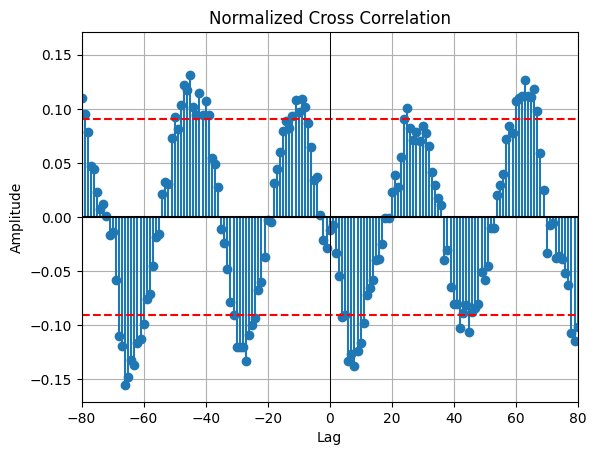

In [173]:
final_corr = analysis.ccf(x, final_resid, numLags=M, plotIt=False)
analysis.ccf(x, BJ_model.resid, numLags=M)